## Setup


In [1]:
import numpy as np
import os
from typing import Sequence

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import OPTICS
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import BallTree
from torch.utils.data import Dataset, DataLoader
import pandas as pd

## Simulation


In [2]:
seed = 99
save_plot = False
use_cached_distance_matrix = True


np.random.seed(seed)

cases = generate_cases(1000)
results = evaluate_cases(cases)
trajectories = [r.trajectory for r in results if not r.simulation_failed]
valid_results = [r for r in results if not r.simulation_failed]
print(f"Generated {len(trajectories)} valid trajectories")
print(
    f"Crashed: {sum(1 for r in valid_results if r.crashed)}, Safe: {sum(1 for r in valid_results if not r.crashed)}"
)

Generated 328 valid trajectories
Crashed: 204, Safe: 124


In [3]:
os.makedirs("cache", exist_ok=True)
distance_matrix_file = f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"

if use_cached_distance_matrix and os.path.exists(distance_matrix_file):
    print(f"Loading altitude-based distance matrix from {distance_matrix_file}")
    distance_matrix = np.load(distance_matrix_file)
else:
    print("Calculating pairwise altitude distances...")
    distance_matrix = pairwise_distances(trajectories)
    np.save(distance_matrix_file, distance_matrix)
    print(f"Distance matrix saved to {distance_matrix_file}")

print(f"Distance matrix shape: {distance_matrix.shape}")

Loading altitude-based distance matrix from cache/distance_matrix_seed99_size328.npy
Distance matrix shape: (328, 328)


## OPTIC Clustering


In [4]:
# OPTICS clustering based on altitude trajectories
optics = OPTICS(min_samples=3, metric="precomputed", cluster_method="xi", xi=0.05)
clusters = optics.fit_predict(distance_matrix)
unique_clusters = np.unique(clusters)
reachability = optics.reachability_
ordering = optics.ordering_

# Calculate cluster statistics
print("Cluster statistics:")
for cluster_id in unique_clusters:
    if cluster_id == -1:  # Skip noise points
        continue
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = len(cluster_results)
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    print(
        f"    Cluster {cluster_id}: {crashed_in_cluster}/{total_in_cluster} crashed ({crash_rate:.2f}%)"
    )

Cluster statistics:
    Cluster 0: 7/12 crashed (58.33%)
    Cluster 1: 5/5 crashed (100.00%)
    Cluster 2: 0/4 crashed (0.00%)
    Cluster 3: 0/5 crashed (0.00%)
    Cluster 4: 0/3 crashed (0.00%)
    Cluster 5: 3/3 crashed (100.00%)
    Cluster 6: 3/5 crashed (60.00%)
    Cluster 7: 1/4 crashed (25.00%)
    Cluster 8: 4/7 crashed (57.14%)
    Cluster 9: 1/3 crashed (33.33%)
    Cluster 10: 0/4 crashed (0.00%)
    Cluster 11: 4/4 crashed (100.00%)
    Cluster 12: 8/8 crashed (100.00%)
    Cluster 13: 3/3 crashed (100.00%)
    Cluster 14: 11/11 crashed (100.00%)
    Cluster 15: 6/6 crashed (100.00%)
    Cluster 16: 5/5 crashed (100.00%)
    Cluster 17: 5/5 crashed (100.00%)
    Cluster 18: 3/3 crashed (100.00%)
    Cluster 19: 3/4 crashed (75.00%)
    Cluster 20: 0/5 crashed (0.00%)
    Cluster 21: 7/7 crashed (100.00%)
    Cluster 22: 0/5 crashed (0.00%)
    Cluster 23: 3/3 crashed (100.00%)
    Cluster 24: 0/4 crashed (0.00%)
    Cluster 25: 0/5 crashed (0.00%)
    Cluster 26: 0/3 c

In [5]:
# Calculate coverage metrics
total_test_cases = len(valid_results)
noise_points = np.sum(clusters == -1)
cluster_ids = unique_clusters[unique_clusters != -1]  # Exclude noise
num_clusters = len(cluster_ids)

# Calculate cluster sizes and proportions
cluster_sizes = {}
cluster_proportions = {}
cluster_coverage_percentages = {}

for cluster_id in cluster_ids:
    cluster_mask = clusters == cluster_id
    size = np.sum(cluster_mask)
    cluster_sizes[cluster_id] = size
    cluster_proportions[cluster_id] = (
        size / total_test_cases if total_test_cases > 0 else 0
    )
    cluster_coverage_percentages[cluster_id] = cluster_proportions[cluster_id] * 100

# Store coverage metrics
coverage_metrics = {
    "total_test_cases": total_test_cases,
    "num_clusters": num_clusters,
    "noise_points": noise_points,
    "noise_percentage": (
        (noise_points / total_test_cases * 100) if total_test_cases > 0 else 0
    ),
    "cluster_sizes": cluster_sizes,
    "cluster_proportions": cluster_proportions,
    "cluster_coverage_percentages": cluster_coverage_percentages,
}

In [6]:
# Print coverage metrics summary
print("=" * 60)
print("OPTICS ALTITUDE-BASED CLUSTERING COVERAGE METRICS SUMMARY")
print("=" * 60)
print(f"\nTotal Test Cases: {coverage_metrics['total_test_cases']}")
print(f"Number of Clusters: {coverage_metrics['num_clusters']}")
print(
    f"Noise Points: {coverage_metrics['noise_points']} ({coverage_metrics['noise_percentage']:.2f}%)"
)
print(f"\nCluster Distribution:")
print("-" * 60)

# Sort clusters by size (descending)
sorted_clusters = sorted(cluster_ids, key=lambda x: cluster_sizes[x], reverse=True)

for cluster_id in sorted_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = cluster_sizes[cluster_id]
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    coverage_pct = cluster_coverage_percentages[cluster_id]

    print(
        f"Cluster {cluster_id:2d}: Size={total_in_cluster:3d} ({coverage_pct:5.2f}% coverage) | "
        f"Crashed={crashed_in_cluster:3d}/{total_in_cluster:3d} ({crash_rate:5.2f}%)"
    )

print("-" * 60)

# Calculate cluster size statistics
if len(cluster_sizes) > 0:
    sizes_list = list(cluster_sizes.values())
    print(f"\nCluster Size Statistics:")
    print(f"  Min: {min(sizes_list)}")
    print(f"  Max: {max(sizes_list)}")
    print(f"  Mean: {np.mean(sizes_list):.2f}")
    print(f"  Median: {np.median(sizes_list):.2f}")
    print(f"  Std Dev: {np.std(sizes_list):.2f}")

# Coverage distribution analysis
coverage_values = list(cluster_coverage_percentages.values())
if len(coverage_values) > 0:
    print(f"\nCoverage Distribution:")
    print(f"  Min Coverage: {min(coverage_values):.2f}%")
    print(f"  Max Coverage: {max(coverage_values):.2f}%")
    print(f"  Mean Coverage: {np.mean(coverage_values):.2f}%")
    print(
        f"  Coverage Balance Score: {1 - np.std(coverage_values) / np.mean(coverage_values):.3f} "
        + f"(1.0 = perfectly balanced, lower = more skewed)"
    )

print("=" * 60)

OPTICS ALTITUDE-BASED CLUSTERING COVERAGE METRICS SUMMARY

Total Test Cases: 328
Number of Clusters: 32
Noise Points: 174 (53.05%)

Cluster Distribution:
------------------------------------------------------------
Cluster  0: Size= 12 ( 3.66% coverage) | Crashed=  7/ 12 (58.33%)
Cluster 14: Size= 11 ( 3.35% coverage) | Crashed= 11/ 11 (100.00%)
Cluster 12: Size=  8 ( 2.44% coverage) | Crashed=  8/  8 (100.00%)
Cluster  8: Size=  7 ( 2.13% coverage) | Crashed=  4/  7 (57.14%)
Cluster 21: Size=  7 ( 2.13% coverage) | Crashed=  7/  7 (100.00%)
Cluster 15: Size=  6 ( 1.83% coverage) | Crashed=  6/  6 (100.00%)
Cluster  1: Size=  5 ( 1.52% coverage) | Crashed=  5/  5 (100.00%)
Cluster  3: Size=  5 ( 1.52% coverage) | Crashed=  0/  5 ( 0.00%)
Cluster  6: Size=  5 ( 1.52% coverage) | Crashed=  3/  5 (60.00%)
Cluster 16: Size=  5 ( 1.52% coverage) | Crashed=  5/  5 (100.00%)
Cluster 17: Size=  5 ( 1.52% coverage) | Crashed=  5/  5 (100.00%)
Cluster 20: Size=  5 ( 1.52% coverage) | Crashed=  0

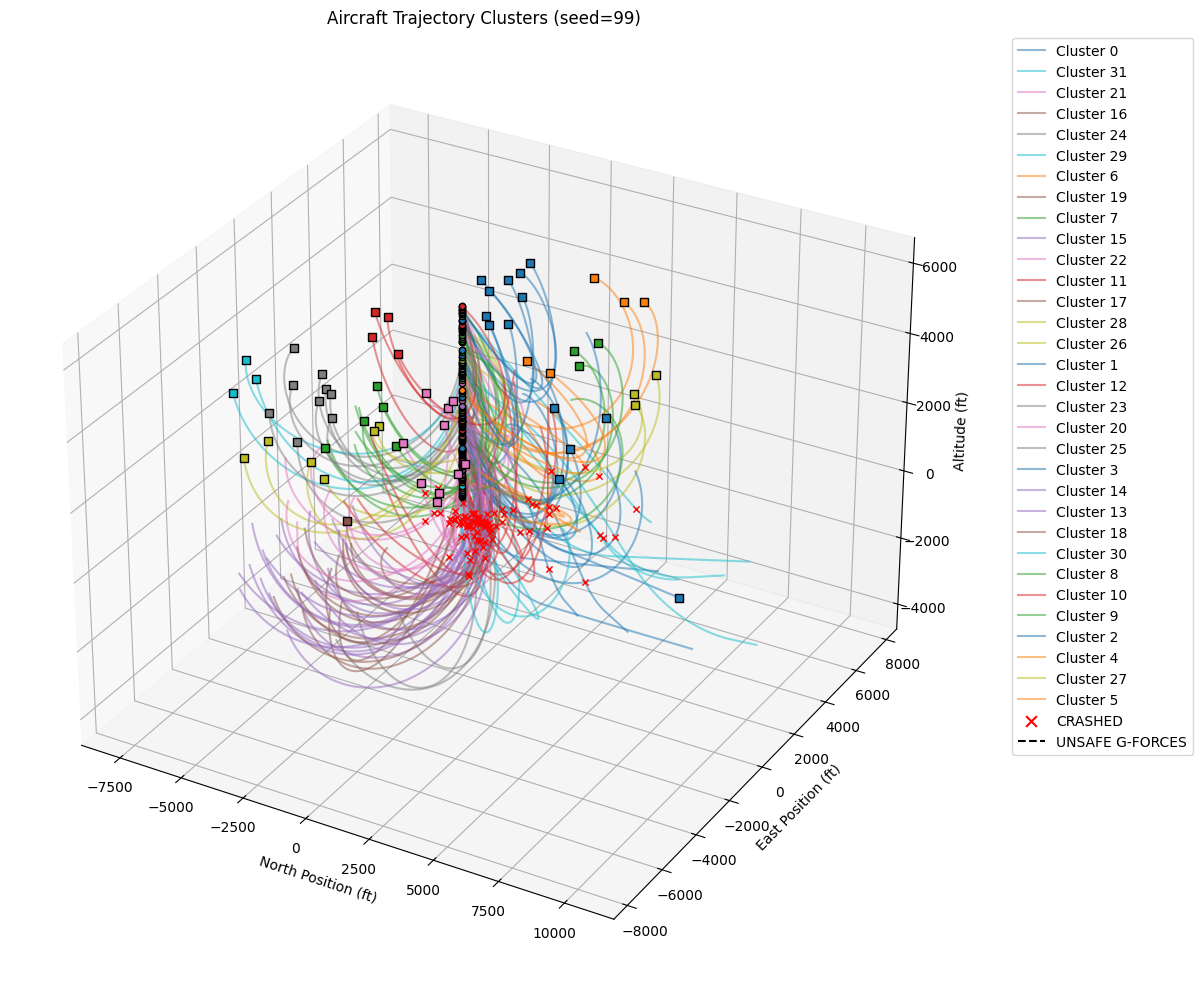

In [7]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

valid_results = [r for r in results if not r.simulation_failed]

plotted_clusters = set()

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]
    if cluster_id not in plotted_clusters:
        label = f"Cluster {cluster_id}"
        plotted_clusters.add(cluster_id)
    else:
        label = None

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )
    else:
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

# Add legend for unsafe g-forces
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_3d.png")
    print(f"Plot saved to results/{seed}_clusters_3d.png")

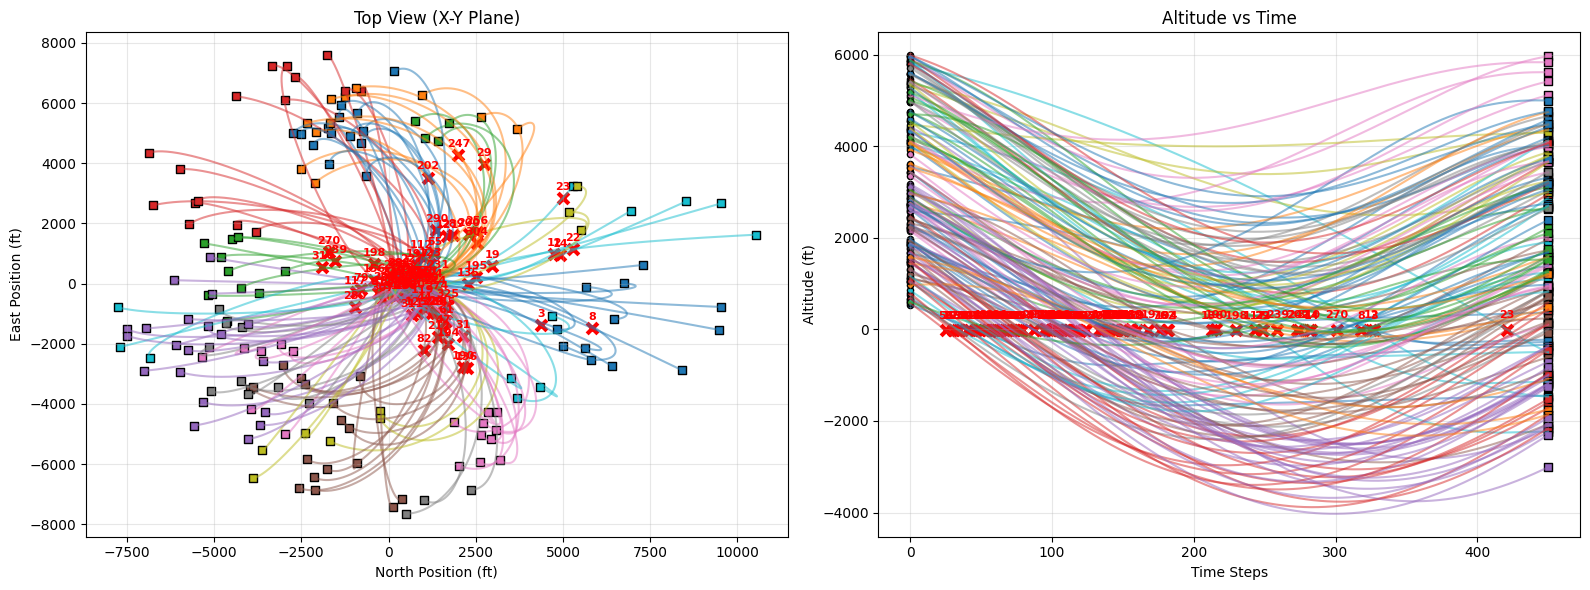

In [8]:
# 2D plotting - x-y plane and altitude vs time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# x-y plane
ax1 = axes[0]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    if result.crashed:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]

        ax1.scatter(
            crash_x,
            crash_y,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax1.text(
            crash_x,
            crash_y + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax1.plot(
            traj[:, 0],
            traj[:, 1],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

    ax1.scatter(
        traj[0, 0],
        traj[0, 1],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax1.scatter(
        traj[-1, 0],
        traj[-1, 1],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax1.set_xlabel("North Position (ft)")
ax1.set_ylabel("East Position (ft)")
ax1.set_title("Top View (X-Y Plane)")
ax1.grid(True, alpha=0.3)

# altitude vs time
ax2 = axes[1]
for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    if cluster_id == -1:  # Skip noise points
        continue

    color = colors[cluster_id % len(colors)]

    time_steps = np.arange(len(traj))

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    if result.crashed:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_time = time_steps[crash_idx]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_time = time_steps[min_alt_idx]
            crash_z = traj[min_alt_idx, 2]

        ax2.scatter(
            crash_time,
            crash_z,
            color="red",
            s=60,
            marker="x",
            linewidth=3,
        )

        ax2.text(
            crash_time,
            crash_z + 200,
            f"{i}",
            color="red",
            fontsize=8,
            fontweight="bold",
            ha="center",
            va="bottom",
        )
    else:
        ax2.plot(
            time_steps,
            traj[:, 2],
            color=color,
            alpha=0.5,
            linewidth=1.5,
            linestyle=line_style,
        )

    ax2.scatter(
        0,
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    ax2.scatter(
        len(traj) - 1,
        traj[-1, 2],
        color=color,
        s=30,
        marker="s",
        edgecolor="black",
        linewidth=1,
    )

ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Altitude (ft)")
ax2.set_title("Altitude vs Time")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
if save_plot:
    plt.savefig(f"results/{seed}_clusters_2d.png")
    print(f"2D plots saved to results/{seed}_clusters_2d.png")

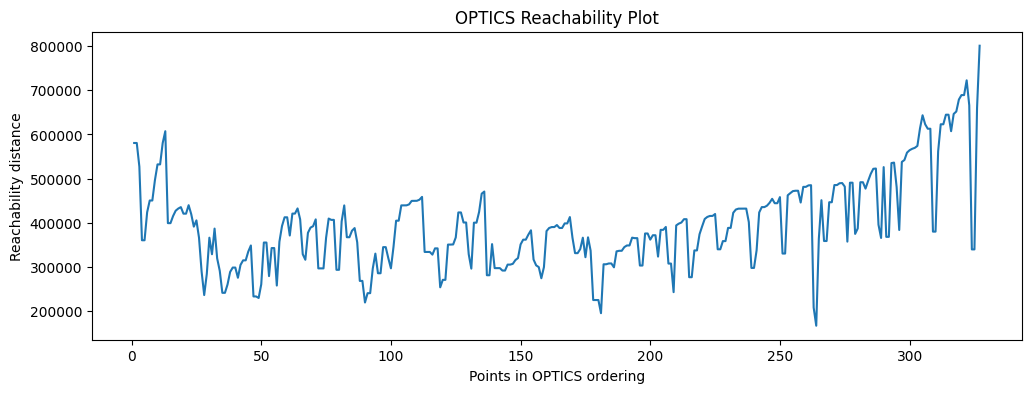

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(reachability[ordering])
plt.xlabel("Points in OPTICS ordering")
plt.ylabel("Reachability distance")
plt.title("OPTICS Reachability Plot")
plt.show()

## Gaussian Mixture Model (GMM) Clustering


In [4]:
# Apply MDS to convert altitude-based distance matrix to feature space
print("Applying MDS transformation...")
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=seed)
X_transformed = mds.fit_transform(distance_matrix)
print(f"MDS transformed features shape: {X_transformed.shape}")
print(f"MDS stress: {mds.stress_:.4f}")

Applying MDS transformation...


/Users/y65ng/Developer/unc/research/code/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


MDS transformed features shape: (328, 2)
MDS stress: 9584082498495042.0000


In [5]:
# Apply GMM clustering with n=5 components based on altitude trajectories
n_components = 5
print(f"Applying GMM clustering with {n_components} components...")
gmm = GaussianMixture(n_components=n_components, random_state=seed)
gmm.fit(X_transformed)

# Apply clustering
clusters = gmm.predict(X_transformed)
cluster_probs = gmm.predict_proba(X_transformed)
unique_clusters = np.unique(clusters)

Applying GMM clustering with 5 components...


In [6]:
# Calculate cluster statistics
for cluster_id in unique_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    crashed_in_cluster = sum(1 for r in cluster_results if r.crashed)
    total_in_cluster = len(cluster_results)
    crash_rate = (
        (crashed_in_cluster / total_in_cluster) * 100 if total_in_cluster > 0 else 0
    )
    print(
        f"Cluster {cluster_id}: {crashed_in_cluster}/{total_in_cluster} crashed ({crash_rate:.2f}%)"
    )

Cluster 0: 27/71 crashed (38.03%)
Cluster 1: 46/63 crashed (73.02%)
Cluster 2: 46/84 crashed (54.76%)
Cluster 3: 31/44 crashed (70.45%)
Cluster 4: 54/66 crashed (81.82%)


In [7]:
# Second-stage clustering on mixed (neither all-crashed nor all-safe) clusters
# Identify mixed clusters from the first-stage GMM
mixed_cluster_ids = []
for cluster_id in unique_clusters:
    mask = clusters == cluster_id
    total = int(np.sum(mask))
    if total == 0:
        continue
    crashed = sum(
        1 for i in range(len(valid_results)) if mask[i] and valid_results[i].crashed
    )
    if 0 < crashed < total:
        mixed_cluster_ids.append(int(cluster_id))

print(f"Mixed clusters selected for separate re-clustering: {mixed_cluster_ids}")

# Perform second-stage clustering separately within each mixed cluster
second_stage_results = []  # list of dicts: {parent_id, X, clusters, valid_results}
for parent_id in mixed_cluster_ids:
    parent_mask = clusters == parent_id
    X_parent = X_transformed[parent_mask]
    valid_results_parent = [res for res, m in zip(valid_results, parent_mask) if m]

    print(f"Parent cluster {parent_id}: {len(valid_results_parent)} samples")

    if len(valid_results_parent) >= 2:
        n_components_parent = 5 if len(valid_results_parent) >= 2 else 1
        print(
            f"  Re-clustering parent {parent_id} with {n_components_parent} components..."
        )
        gmm_parent = GaussianMixture(
            n_components=n_components_parent, random_state=seed
        )
        gmm_parent.fit(X_parent)
        clusters_parent = gmm_parent.predict(X_parent)

        # Report stats per second-stage subcluster
        for sub_id in np.unique(clusters_parent):
            sub_mask = clusters_parent == sub_id
            sub_results = [
                valid_results_parent[i]
                for i in range(len(valid_results_parent))
                if sub_mask[i]
            ]
            crashed_in_sub = sum(1 for r in sub_results if r.crashed)
            total_in_sub = len(sub_results)
            crash_rate_sub = (
                (crashed_in_sub / total_in_sub) * 100 if total_in_sub > 0 else 0
            )
            print(
                f"  Parent {parent_id} -> Sub {sub_id}: {crashed_in_sub}/{total_in_sub} crashed ({crash_rate_sub:.2f}%)"
            )

        second_stage_results.append(
            {
                "parent_id": int(parent_id),
                "X": X_parent,
                "clusters": clusters_parent,
                "valid_results": valid_results_parent,
            }
        )
    else:
        print(
            f"  Not enough samples in parent {parent_id} for re-clustering; skipping."
        )

Mixed clusters selected for separate re-clustering: [0, 1, 2, 3, 4]
Parent cluster 0: 71 samples
  Re-clustering parent 0 with 5 components...
  Parent 0 -> Sub 0: 5/6 crashed (83.33%)
  Parent 0 -> Sub 1: 3/15 crashed (20.00%)
  Parent 0 -> Sub 2: 7/12 crashed (58.33%)
  Parent 0 -> Sub 3: 0/12 crashed (0.00%)
  Parent 0 -> Sub 4: 12/26 crashed (46.15%)
Parent cluster 1: 63 samples
  Re-clustering parent 1 with 5 components...
  Parent 1 -> Sub 0: 7/7 crashed (100.00%)
  Parent 1 -> Sub 1: 9/17 crashed (52.94%)
  Parent 1 -> Sub 2: 13/15 crashed (86.67%)
  Parent 1 -> Sub 3: 9/11 crashed (81.82%)
  Parent 1 -> Sub 4: 8/13 crashed (61.54%)
Parent cluster 2: 84 samples
  Re-clustering parent 2 with 5 components...
  Parent 2 -> Sub 0: 20/24 crashed (83.33%)
  Parent 2 -> Sub 1: 15/27 crashed (55.56%)
  Parent 2 -> Sub 2: 2/13 crashed (15.38%)
  Parent 2 -> Sub 3: 9/9 crashed (100.00%)
  Parent 2 -> Sub 4: 0/11 crashed (0.00%)
Parent cluster 3: 44 samples
  Re-clustering parent 3 with 5 

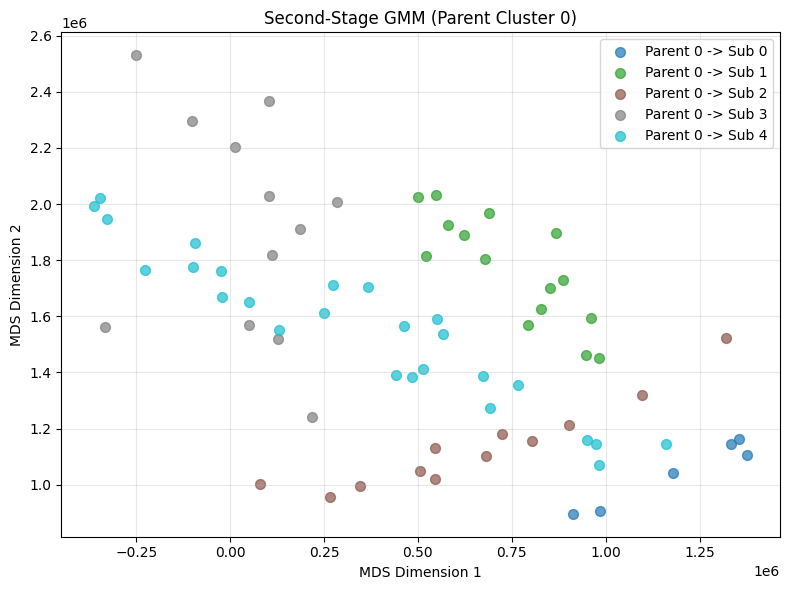

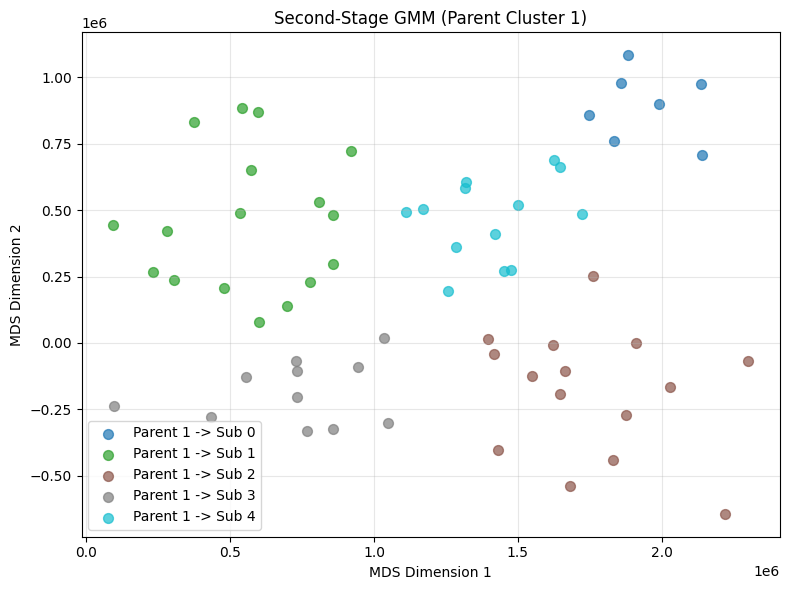

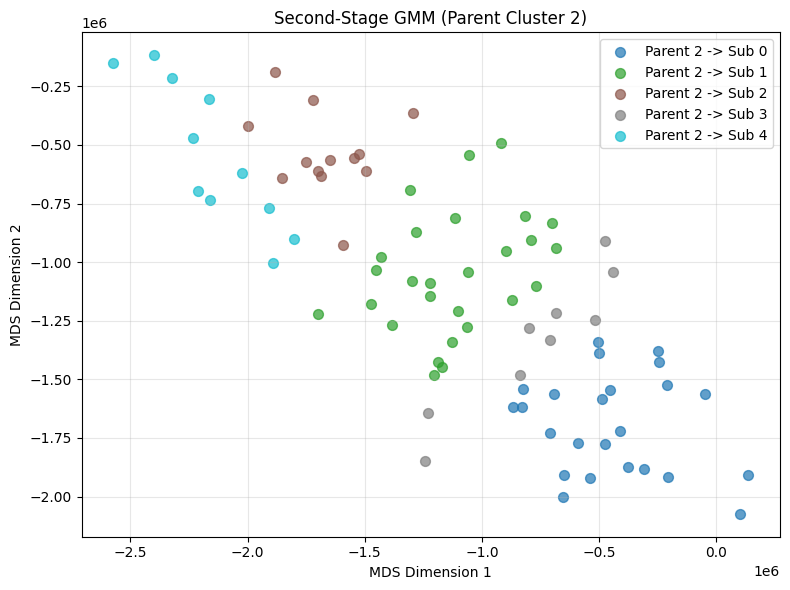

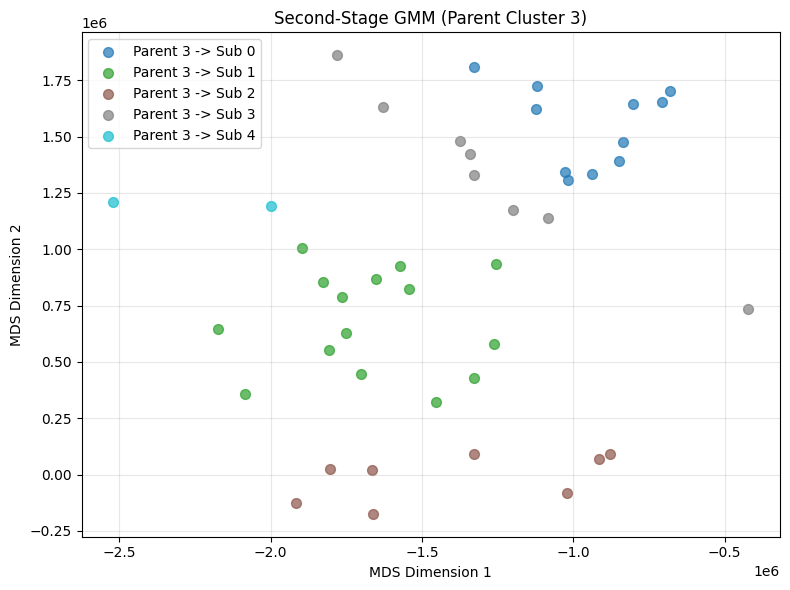

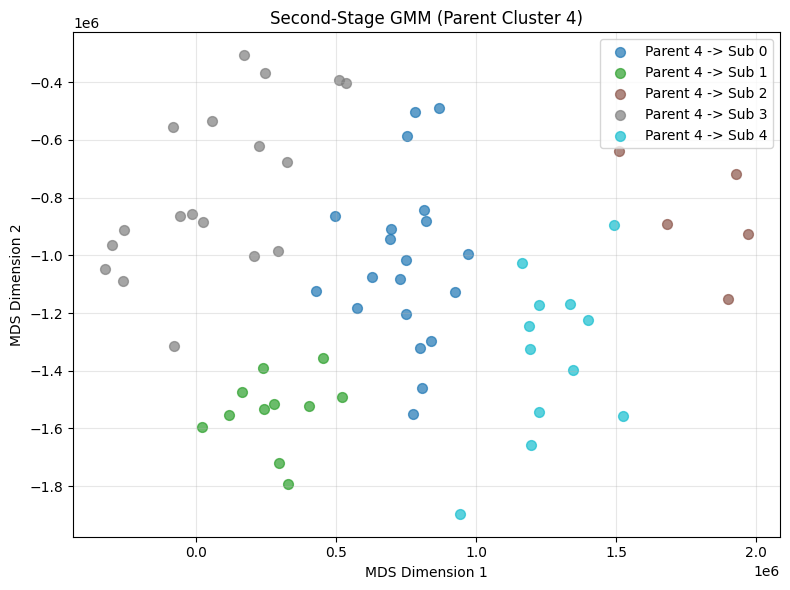

In [8]:
# Visualize second-stage clusters per parent (MDS space)
if "second_stage_results" in globals() and len(second_stage_results) > 0:
    for res in second_stage_results:
        parent_id = res["parent_id"]
        Xp = res["X"]
        cp = res["clusters"]
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(np.unique(cp))))
        for sub_id in np.unique(cp):
            mask = cp == sub_id
            ax.scatter(
                Xp[mask, 0],
                Xp[mask, 1],
                c=[colors[sub_id % len(colors)]],
                label=f"Parent {parent_id} -> Sub {sub_id}",
                alpha=0.7,
                s=50,
            )
        ax.set_xlabel("MDS Dimension 1")
        ax.set_ylabel("MDS Dimension 2")
        ax.set_title(f"Second-Stage GMM (Parent Cluster {parent_id})")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("Second-stage clustering results not available.")

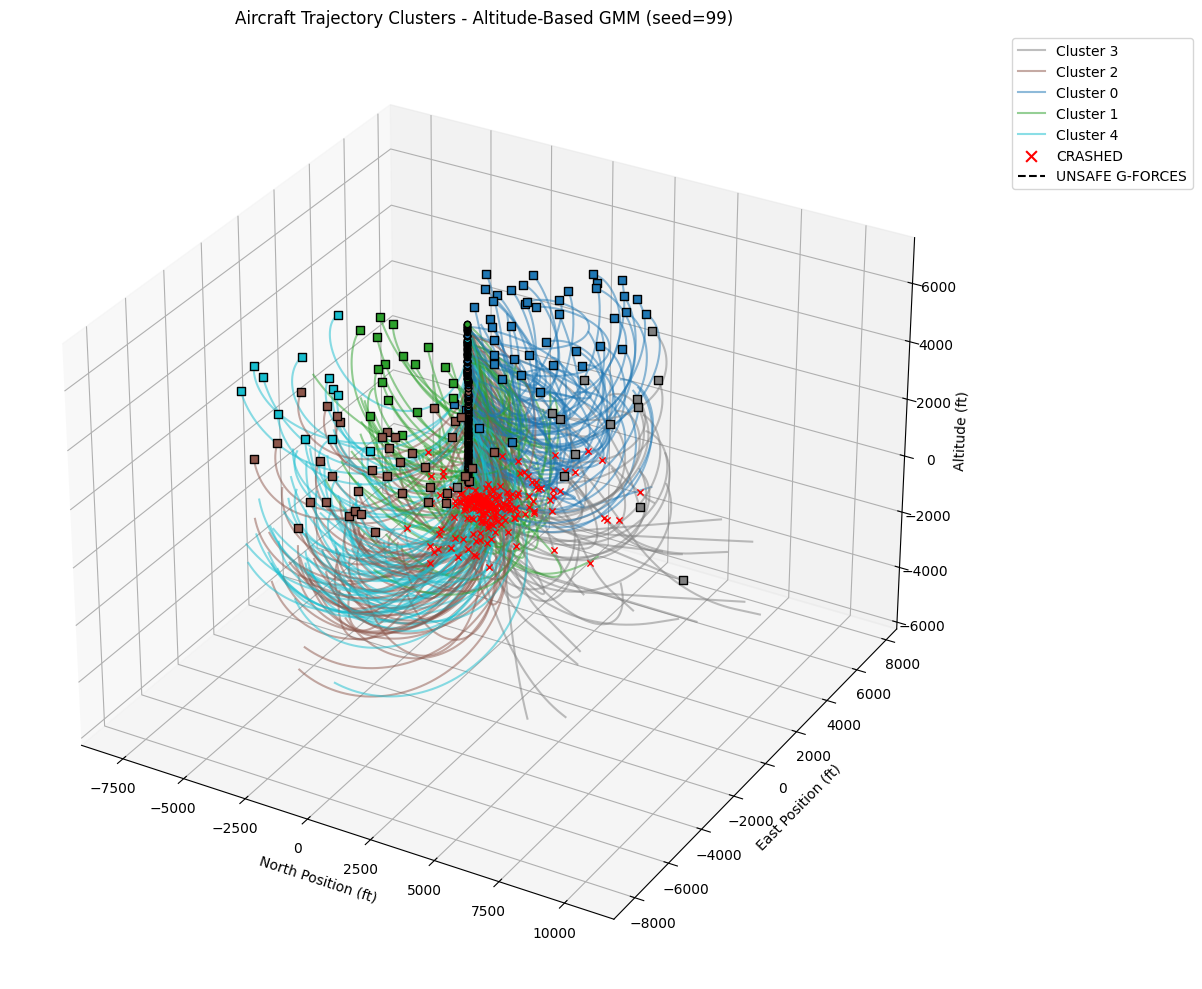

In [9]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

plotted_clusters = set()

for i, (traj, cluster_id, result) in enumerate(
    zip(trajectories, clusters, valid_results)
):
    color = colors[cluster_id % len(colors)]
    if cluster_id not in plotted_clusters:
        label = f"Cluster {cluster_id}"
        plotted_clusters.add(cluster_id)
    else:
        label = None

    # Check for unsafe g-forces
    has_unsafe_g = has_unsafe_gforces(traj)
    line_style = "--" if has_unsafe_g else "-"

    ax.plot(
        traj[:, 0],
        traj[:, 1],
        traj[:, 2],
        color=color,
        alpha=0.5,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # start point
    ax.scatter(
        traj[0, 0],
        traj[0, 1],
        traj[0, 2],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
    )

    # end points
    if result.crashed:
        # Find the exact crashed point using first time alt <= 0
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]  # First occurrence
            crash_x = traj[crash_idx, 0]
            crash_y = traj[crash_idx, 1]
            crash_z = traj[crash_idx, 2]
        else:
            # Fallback to minimum altitude if no point <= 0
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_x = traj[min_alt_idx, 0]
            crash_y = traj[min_alt_idx, 1]
            crash_z = traj[min_alt_idx, 2]

        ax.scatter(
            crash_x,
            crash_y,
            crash_z,
            color="red",
            s=20,
            marker="x",
            linewidth=1,
        )
    else:
        # Safe landing point
        ax.scatter(
            traj[-1, 0],
            traj[-1, 1],
            traj[-1, 2],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
        )

# Add legend for crashed trajectories
if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")

# Add legend for unsafe g-forces
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("North Position (ft)")
ax.set_ylabel("East Position (ft)")
ax.set_zlabel("Altitude (ft)")
ax.set_title(f"Aircraft Trajectory Clusters - Altitude-Based GMM (seed={seed})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
if save_plot:
    plt.savefig(
        f"results/gmm_{n_components}_clusters_3d.png", dpi=300, bbox_inches="tight"
    )
    print(f"Plot saved to results/gmm_{n_components}_clusters_3d.png")

plt.show()

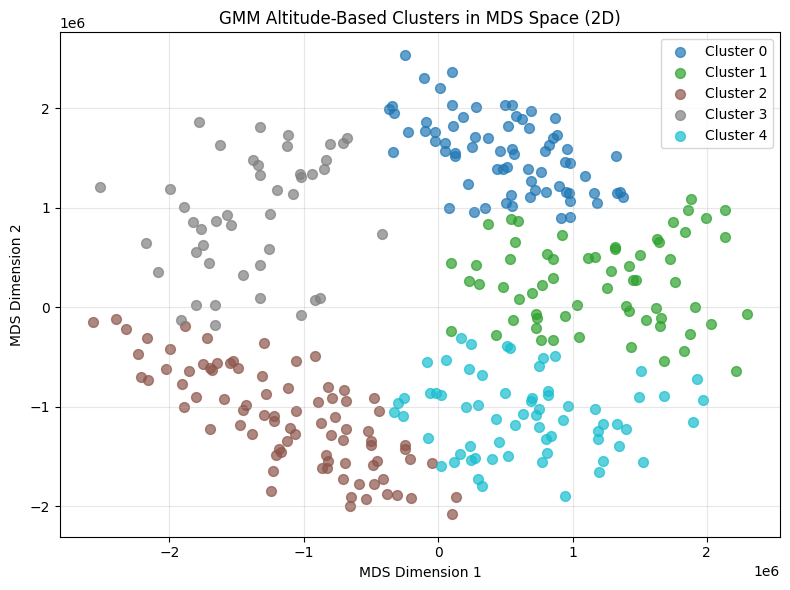

In [10]:
# Visualize clusters in MDS space
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

for cluster_id in unique_clusters:
    mask = clusters == cluster_id
    color = colors[cluster_id % len(colors)]

    # Plot first two MDS dimensions
    ax1.scatter(
        X_transformed[mask, 0],
        X_transformed[mask, 1],
        c=[color],
        label=f"Cluster {cluster_id}",
        alpha=0.7,
        s=50,
    )

ax1.set_xlabel("MDS Dimension 1")
ax1.set_ylabel("MDS Dimension 2")
ax1.set_title("GMM Altitude-Based Clusters in MDS Space (2D)")
ax1.legend()
ax1.grid(True, alpha=0.3)


plt.tight_layout()

if save_plot:
    plt.savefig(
        f"results/gmm_{n_components}_clusters_mds.png",
        dpi=300,
        bbox_inches="tight",
    )
    print(f"MDS plot saved to results/gmm_{n_components}_clusters_mds.png")

plt.show()

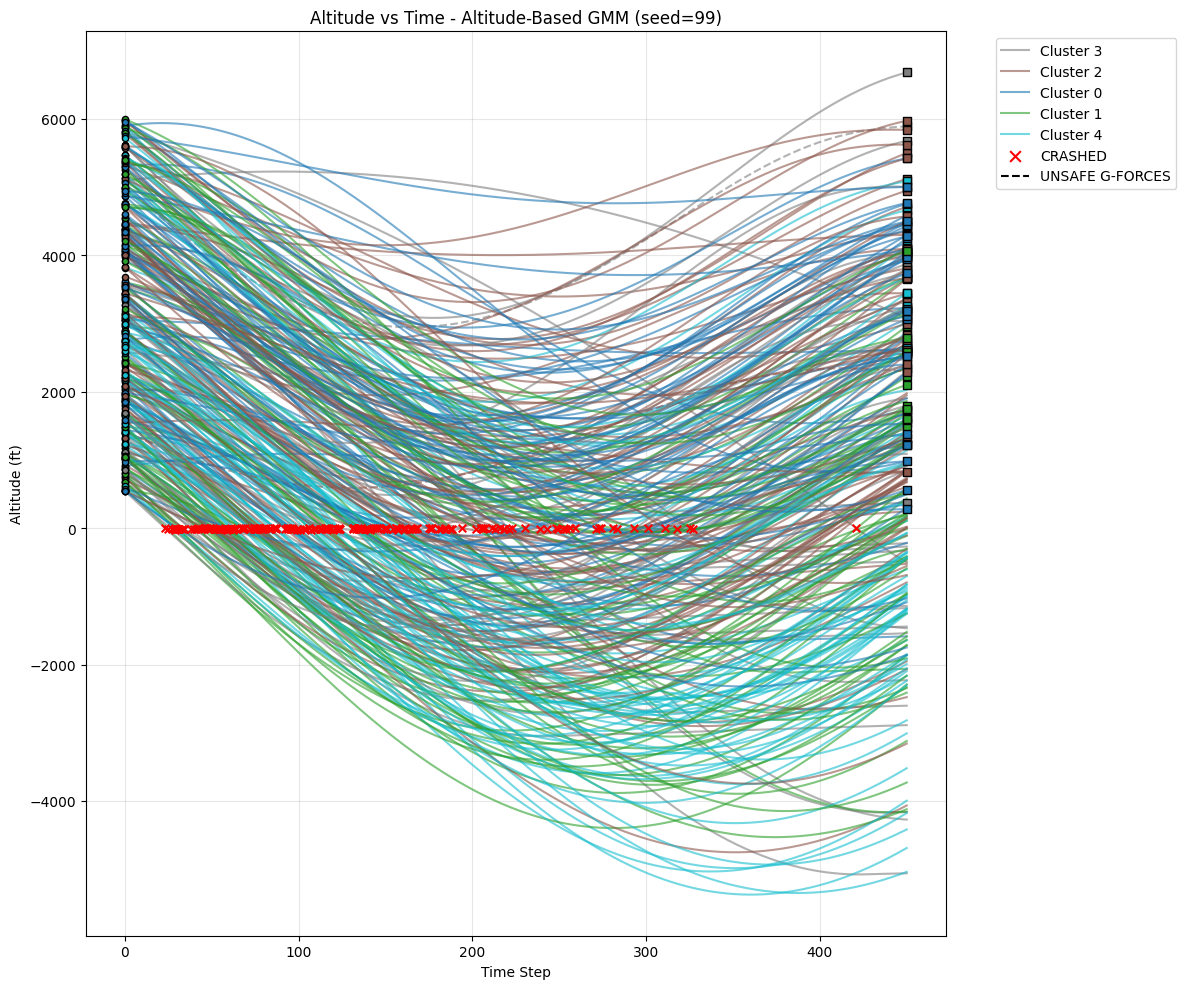

In [11]:
# Altitude vs Time Visualization
fig, ax = plt.subplots(figsize=(12, 10))

colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))
plotted_clusters = set()

for traj, cluster_id, result in zip(trajectories, clusters, valid_results):
    color = colors[cluster_id % len(colors)]
    label = f"Cluster {cluster_id}" if cluster_id not in plotted_clusters else None
    plotted_clusters.add(cluster_id)

    # Style for unsafe g-forces
    line_style = "--" if has_unsafe_gforces(traj) else "-"

    # Time index and altitude
    t = np.arange(traj.shape[0])
    alt = traj[:, 2]

    # Plot altitude vs time
    ax.plot(
        t,
        alt,
        color=color,
        alpha=0.6,
        linewidth=1.5,
        linestyle=line_style,
        label=label,
    )

    # Start point
    ax.scatter(
        0,
        alt[0],
        color=color,
        s=20,
        marker="o",
        edgecolor="black",
        linewidth=1,
        zorder=3,
    )

    # End point (crash or safe)
    if result.crashed:
        crash_idx = np.where(traj[:, 2] <= 0)[0]
        if len(crash_idx) > 0:
            crash_idx = crash_idx[0]
            crash_t = crash_idx
            crash_alt = alt[crash_idx]
        else:
            min_alt_idx = np.argmin(result.trajectory[:, 2])
            crash_t = min_alt_idx
            crash_alt = alt[min_alt_idx]
        ax.scatter(
            crash_t, crash_alt, color="red", s=30, marker="x", linewidth=1.5, zorder=4
        )
    else:
        ax.scatter(
            t[-1],
            alt[-1],
            color=color,
            s=30,
            marker="s",
            edgecolor="black",
            linewidth=1,
            zorder=4,
        )

# Legend handles
if any(result.crashed for result in valid_results):
    ax.scatter([], [], color="red", marker="x", s=60, label="CRASHED")
if any(has_unsafe_gforces(traj) for traj in trajectories):
    ax.plot([], [], color="black", linestyle="--", label="UNSAFE G-FORCES")

ax.set_xlabel("Time Step")
ax.set_ylabel("Altitude (ft)")
ax.set_title(f"Altitude vs Time - Altitude-Based GMM (seed={seed})")
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()

if save_plot:
    os.makedirs("results", exist_ok=True)
    plt.savefig(
        f"results/gmm_{n_components}_clusters_altitude_time.png",
        dpi=300,
        bbox_inches="tight",
    )
    print(f"Plot saved to results/gmm_{n_components}_clusters_altitude_time.png")

plt.show()

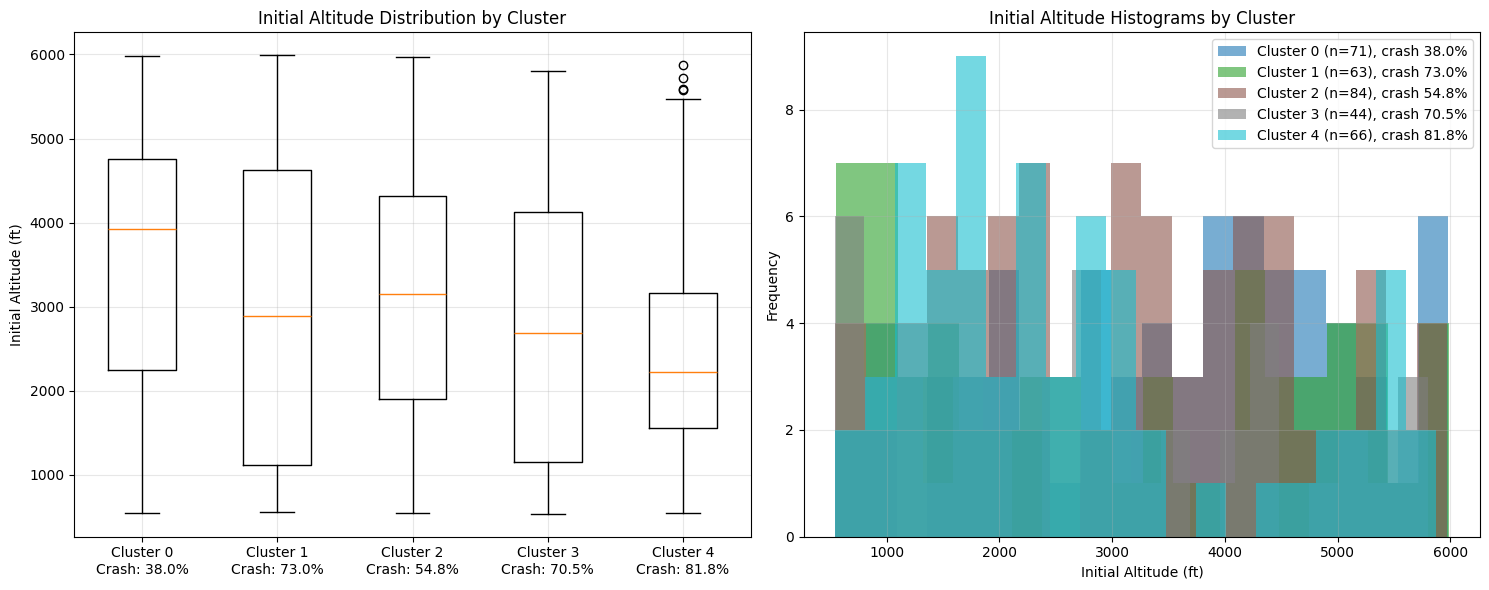

In [12]:
# Visualize altitude distributions by cluster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot of altitude by cluster
cluster_alts = []
cluster_labels = []
for cluster_id in unique_clusters:
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    cluster_altitudes = [r.test_case.alt for r in cluster_results]
    crashed_count = sum(1 for r in cluster_results if r.crashed)
    total_count = len(cluster_results)
    crash_rate = (crashed_count / total_count) * 100 if total_count > 0 else 0.0
    cluster_alts.append(cluster_altitudes)
    cluster_labels.append(f"Cluster {cluster_id}\nCrash: {crash_rate:.1f}%")

ax1.boxplot(cluster_alts, tick_labels=cluster_labels)
ax1.set_ylabel("Initial Altitude (ft)")
ax1.set_title("Initial Altitude Distribution by Cluster")
ax1.grid(True, alpha=0.3)

# Histogram of altitude distributions
colors = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))
for i, cluster_id in enumerate(unique_clusters):
    cluster_mask = clusters == cluster_id
    cluster_results = [
        valid_results[i] for i in range(len(valid_results)) if cluster_mask[i]
    ]
    cluster_altitudes = [r.test_case.alt for r in cluster_results]
    crashed_count = sum(1 for r in cluster_results if r.crashed)
    total_count = len(cluster_results)
    crash_rate = (crashed_count / total_count) * 100 if total_count > 0 else 0.0

    ax2.hist(
        cluster_altitudes,
        bins=20,
        alpha=0.6,
        label=f"Cluster {cluster_id} (n={len(cluster_altitudes)}), crash {crash_rate:.1f}%",
        color=colors[i % len(colors)],
    )

ax2.set_xlabel("Initial Altitude (ft)")
ax2.set_ylabel("Frequency")
ax2.set_title("Initial Altitude Histograms by Cluster")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Variable -> Crash relationship summary
--------------------------------------------------
Altitude (ft)    | corr=-0.656 | safe mean=4406.29 | crash mean=2254.15
Velocity (ft/s)  | corr=-0.066 | safe mean=719.27 | crash mean=711.03
Alpha (deg)      | corr=-0.073 | safe mean=5.33 | crash mean=4.90
Beta (deg)       | corr=+0.038 | safe mean=-0.97 | crash mean=-0.07
Phi (deg)        | corr=-0.060 | safe mean=8.45 | crash mean=-6.40
Theta (deg)      | corr=+0.016 | safe mean=-49.94 | crash mean=-49.10
Power            | corr=+0.000 | safe mean=9.00 | crash mean=9.00


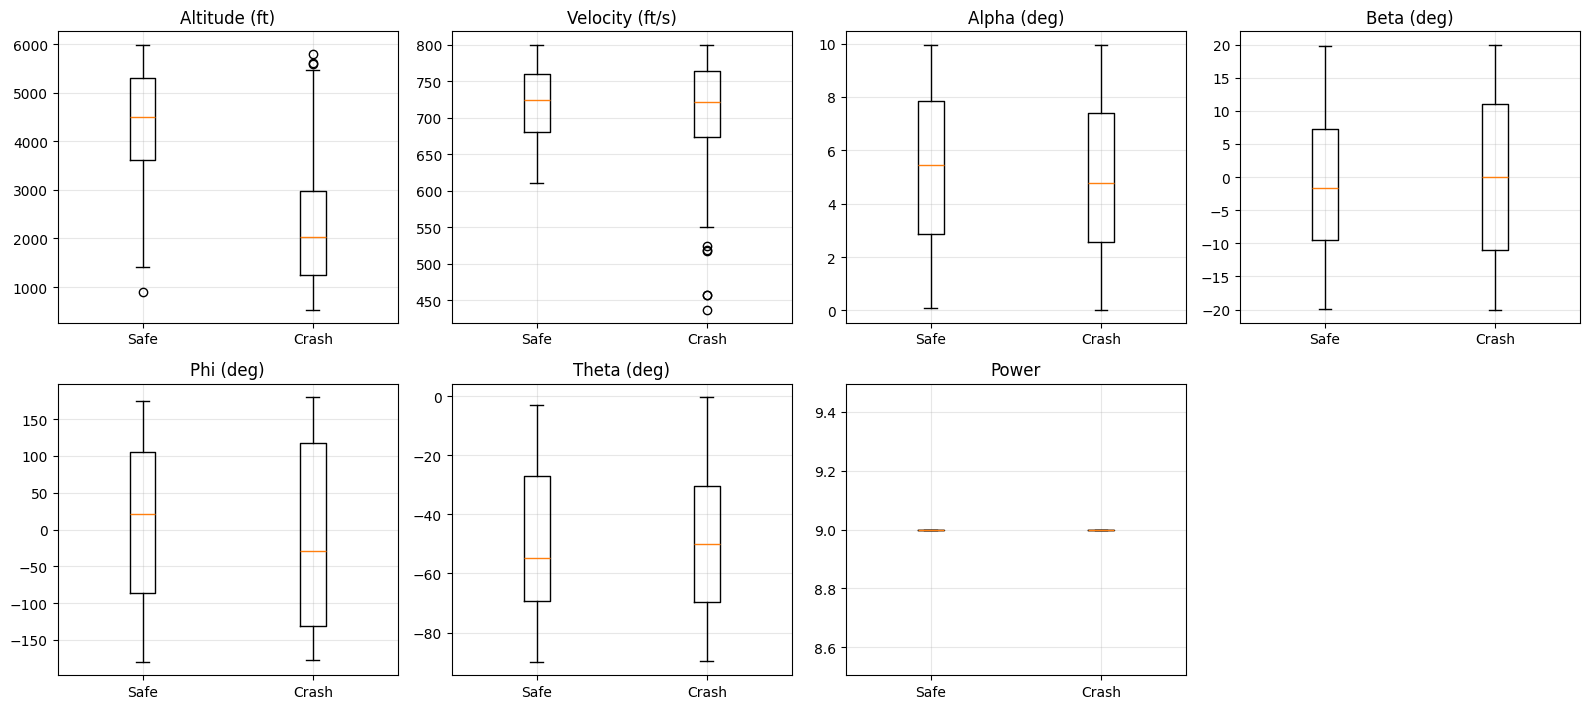

In [13]:
# Relationship of initial variables to crash outcome
from sklearn.metrics import roc_auc_score

# Collect initial variables and crash labels
labels = np.array([1 if r.crashed else 0 for r in valid_results])
vars_dict = {
    "Altitude (ft)": np.array([r.test_case.alt for r in valid_results]),
    "Velocity (ft/s)": np.array([r.test_case.vt for r in valid_results]),
    "Alpha (deg)": np.rad2deg(np.array([r.test_case.alpha for r in valid_results])),
    "Beta (deg)": np.rad2deg(np.array([r.test_case.beta for r in valid_results])),
    "Phi (deg)": np.rad2deg(np.array([r.test_case.phi for r in valid_results])),
    "Theta (deg)": np.rad2deg(np.array([r.test_case.theta for r in valid_results])),
    "Power": np.array([r.test_case.power for r in valid_results]),
}

print("Variable -> Crash relationship summary")
print("-" * 50)
for name, values in vars_dict.items():
    # Pearson correlation with binary label (point-biserial equivalent)
    corr = float(np.corrcoef(values, labels)[0, 1]) if np.std(values) > 0 else 0.0
    safe_vals = values[labels == 0]
    crash_vals = values[labels == 1]
    print(
        f"{name:16s} | corr={corr:+.3f} | safe mean={np.mean(safe_vals):.2f} | crash mean={np.mean(crash_vals):.2f}"
    )

# Boxplots comparing crashed vs safe for each variable
num_vars = len(vars_dict)
cols = 4
rows = int(np.ceil(num_vars / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.6 * rows))
axes = axes.flatten()

for ax, (name, values) in zip(axes, vars_dict.items()):
    data = [values[labels == 0], values[labels == 1]]
    ax.boxplot(data, tick_labels=["Safe", "Crash"])
    ax.set_title(name)
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(len(vars_dict), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Training Util Functions


In [4]:
def testcase_to_ndarray(test_case: TestCase) -> np.ndarray:

    return np.array(
        [
            test_case.vt,
            test_case.alpha,
            test_case.beta,
            test_case.phi,
            test_case.theta,
            test_case.psi,
            test_case.alt,
            test_case.power,
        ]
    )


test_cases = [r.test_case for r in valid_results]
features = np.array([testcase_to_ndarray(case) for case in test_cases])
features.shape


def pair_features_between(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    feat_diff = a - b
    feat_abs_diff = np.abs(feat_diff)
    euclidean_dist = np.linalg.norm(feat_diff)
    angular_indices = [1, 2, 3, 4, 5]
    angular_diffs = []
    for idx in angular_indices:
        d = feat_diff[idx]
        while d > np.pi:
            d -= 2 * np.pi
        while d < -np.pi:
            d += 2 * np.pi
        angular_diffs.append(d)
    return np.concatenate([feat_diff, feat_abs_diff, [euclidean_dist], angular_diffs])


def ndarray_to_testcase(arr: Sequence[float]) -> TestCase:
    return TestCase(
        vt=float(arr[0]),
        alpha=float(arr[1]),
        beta=float(arr[2]),
        phi=float(arr[3]),
        theta=float(arr[4]),
        psi=float(arr[5]),
        alt=float(arr[6]),
        power=float(arr[7]),
    )

In [5]:
def create_pairwise_features(
    features: NDArray[np.float64], distance_matrix: NDArray[np.float64]
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    n = features.shape[0]
    pairwise_features = []
    distances = []

    # Use upper triangular matrix to avoid duplicates
    for i in range(n):
        for j in range(i + 1, n):
            # Feature differences
            feat_diff = features[i] - features[j]
            feat_abs_diff = np.abs(feat_diff)

            # Additional features
            euclidean_dist = np.linalg.norm(feat_diff)

            # Angular differences for angles (alpha, beta, phi, theta, psi)
            angular_indices = [1, 2, 3, 4, 5]  # alpha, beta, phi, theta, psi
            angular_diffs = []
            for idx in angular_indices:
                diff = feat_diff[idx]
                # Normalize to [-pi, pi]
                while diff > np.pi:
                    diff -= 2 * np.pi
                while diff < -np.pi:
                    diff += 2 * np.pi
                angular_diffs.append(diff)

            # Combine all features
            combined_features = np.concatenate(
                [
                    feat_diff,
                    feat_abs_diff,
                    [euclidean_dist],
                    angular_diffs,
                ]
            )

            pairwise_features.append(combined_features)
            distances.append(distance_matrix[i, j])

    return np.array(pairwise_features), np.array(distances)


X, y = create_pairwise_features(features, distance_matrix)

print(f"Pairwise features shape: {X.shape}")
print(f"Distances shape: {y.shape}")

Pairwise features shape: (53628, 22)
Distances shape: (53628,)


## Random Forest Regression


In [6]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 42902 samples
Test set: 10726 samples


In [7]:
initial_cases = [r.test_case for r in valid_results]

In [8]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=99)

In [9]:
# Make predictions
rf_predictions = rf_model.predict(X_test_scaled)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = rf_model.score(X_test_scaled, y_test)


print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R squared: {rf_r2:.4f}")

MAE: 301706.60
RMSE: 401310.33
R squared: 0.7705


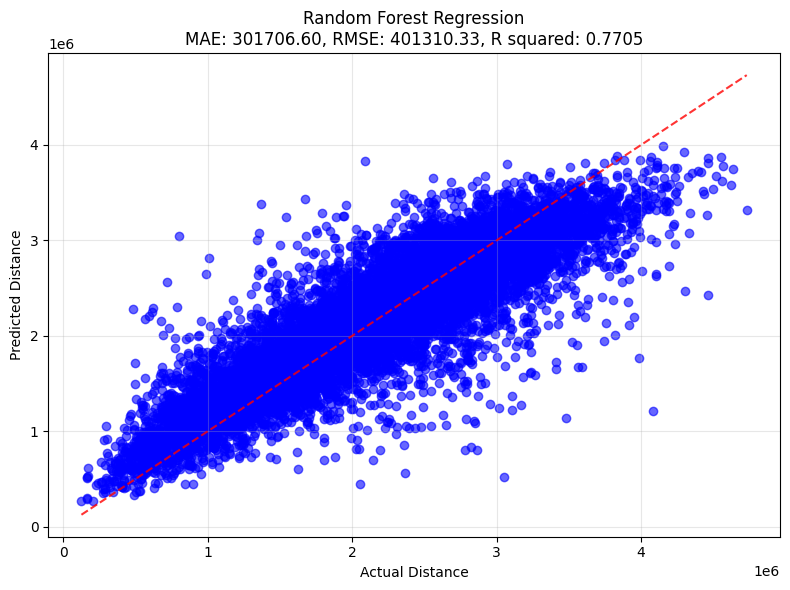

In [10]:
# Visualize results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(y_test, rf_predictions, alpha=0.6, color="blue")
min_val = min(y_test.min(), rf_predictions.min())
max_val = max(y_test.max(), rf_predictions.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
ax.set_xlabel("Actual Distance")
ax.set_ylabel("Predicted Distance")
ax.set_title(
    f"Random Forest Regression\nMAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R squared: {rf_r2:.4f}"
)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Feature importance analysis
feature_names = [
    "vt_diff",
    "alpha_diff",
    "beta_diff",
    "phi_diff",
    "theta_diff",
    "psi_diff",
    "alt_diff",
    "power_diff",
    "vt_abs_diff",
    "alpha_abs_diff",
    "beta_abs_diff",
    "phi_abs_diff",
    "theta_abs_diff",
    "psi_abs_diff",
    "alt_abs_diff",
    "power_abs_diff",
    "euclidean_dist",
    "alpha_angular_diff",
    "beta_angular_diff",
    "phi_angular_diff",
    "theta_angular_diff",
    "psi_angular_diff",
]

# Get feature importances
rf_importances = rf_model.feature_importances_

# Sort features by importance
rf_indices = np.argsort(rf_importances)[::-1]

print("Top 10 Most Important Features:")
for i in range(min(10, len(feature_names))):
    idx = rf_indices[i]
    print(f"  {i+1}. {feature_names[idx]}: {rf_importances[idx]:.4f}")

Top 10 Most Important Features:
  1. phi_abs_diff: 0.6169
  2. euclidean_dist: 0.0758
  3. alt_abs_diff: 0.0681
  4. theta_abs_diff: 0.0318
  5. vt_diff: 0.0314
  6. vt_abs_diff: 0.0261
  7. alt_diff: 0.0205
  8. theta_angular_diff: 0.0169
  9. theta_diff: 0.0165
  10. beta_abs_diff: 0.0148


## Triplet Loss Encoder


In [12]:
class TripletEncoder(nn.Module):
    def __init__(self, input_dim=8, latent_dim=32, normalize_output=True):
        super(TripletEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, latent_dim)
        self.relu = nn.ReLU()
        self.normalize_output = normalize_output

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        if self.normalize_output:
            x = nn.functional.normalize(x, p=2, dim=1)
        return x

In [13]:
# Create TripletDataset class for generating anchor-positive-negative triplets
class TripletDataset(Dataset):
    def __init__(
        self,
        features,
        distance_matrix,
        n_triplets,
        positive_threshold_percentile=20,
        negative_threshold_percentile=80,
        random_seed=100,
    ):
        """
        Args:
            features: numpy array of shape (n_samples, n_features)
            distance_matrix: numpy array of shape (n_samples, n_samples) with DTW distances
            n_triplets: number of triplets to generate
            positive_threshold_percentile: percentile threshold for positive examples (lower = closer)
            negative_threshold_percentile: percentile threshold for negative examples (higher = farther)
            random_seed: random seed for reproducibility
        """
        self.features = features
        self.distance_matrix = distance_matrix
        self.n_triplets = n_triplets
        self.n_samples = len(features)

        np.random.seed(random_seed)
        torch.manual_seed(random_seed)

        # Pre-compute thresholds
        # Get all non-zero distances (excluding diagonal)
        mask = ~np.eye(self.n_samples, dtype=bool)
        all_distances = self.distance_matrix[mask]
        self.positive_threshold = np.percentile(
            all_distances, positive_threshold_percentile
        )
        self.negative_threshold = np.percentile(
            all_distances, negative_threshold_percentile
        )

        # Pre-generate triplets
        self.triplets = []
        max_attempts = 1000
        for _ in range(n_triplets):
            anchor_idx = np.random.randint(0, self.n_samples)
            attempts = 0
            positive_idx = None
            negative_idx = None

            # Find positive (similar to anchor)
            while positive_idx is None and attempts < max_attempts:
                candidate = np.random.randint(0, self.n_samples)
                if candidate != anchor_idx:
                    dist = self.distance_matrix[anchor_idx, candidate]
                    if dist <= self.positive_threshold:
                        positive_idx = candidate
                attempts += 1

            # Find negative (dissimilar to anchor)
            attempts = 0
            while negative_idx is None and attempts < max_attempts:
                candidate = np.random.randint(0, self.n_samples)
                if candidate != anchor_idx and candidate != positive_idx:
                    dist = self.distance_matrix[anchor_idx, candidate]
                    if dist >= self.negative_threshold:
                        negative_idx = candidate
                attempts += 1

            if positive_idx is not None and negative_idx is not None:
                self.triplets.append((anchor_idx, positive_idx, negative_idx))
            elif len(self.triplets) > 0:
                # If we can't find valid triplet, reuse a previous one
                self.triplets.append(self.triplets[-1])

        print(f"Generated {len(self.triplets)} valid triplets")
        print(
            f"Positive threshold (percentile {positive_threshold_percentile}): {self.positive_threshold:.2f}"
        )
        print(
            f"Negative threshold (percentile {negative_threshold_percentile}): {self.negative_threshold:.2f}"
        )

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor_idx, positive_idx, negative_idx = self.triplets[idx]
        anchor = torch.FloatTensor(self.features[anchor_idx])
        positive = torch.FloatTensor(self.features[positive_idx])
        negative = torch.FloatTensor(self.features[negative_idx])
        return anchor, positive, negative

In [14]:
# Implement triplet loss function
def triplet_loss(anchor_emb, positive_emb, negative_emb, margin=0.5):
    """
    Compute triplet loss: max(0, margin + d(anchor, positive) - d(anchor, negative))

    Args:
        anchor_emb: anchor embeddings (batch_size, latent_dim)
        positive_emb: positive embeddings (batch_size, latent_dim)
        negative_emb: negative embeddings (batch_size, latent_dim)
        margin: margin parameter for triplet loss

    Returns:
        Mean triplet loss over batch
    """
    # Compute squared L2 distances
    d_pos = torch.sum((anchor_emb - positive_emb) ** 2, dim=1)
    d_neg = torch.sum((anchor_emb - negative_emb) ** 2, dim=1)

    # Triplet loss: max(0, margin + d_pos - d_neg)
    loss = torch.clamp(margin + d_pos - d_neg, min=0.0)
    return torch.mean(loss)

In [15]:
# Training function for triplet encoder
def train_triplet_encoder(
    features,
    distance_matrix,
    latent_dim=32,
    margin=0.5,
    epochs=50,
    batch_size=64,
    lr=0.001,
    n_triplets=10000,
    random_seed=100,
):

    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Create dataset and dataloader
    dataset = TripletDataset(
        features_scaled, distance_matrix, n_triplets, random_seed=random_seed
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize encoder
    encoder = TripletEncoder(input_dim=features.shape[1], latent_dim=latent_dim)
    optimizer = optim.Adam(encoder.parameters(), lr=lr)

    # Set random seeds
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)

    # Training loop
    encoder.train()
    loss_history = []

    print(f"Training Triplet Encoder...")
    print(f"  Input dimension: {features.shape[1]}")
    print(f"  Latent dimension: {latent_dim}")
    print(f"  Number of triplets: {len(dataset)}")
    print(f"  Batch size: {batch_size}")
    print(f"  Epochs: {epochs}")
    print(f"  Margin: {margin}")
    print()

    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0

        for anchor, positive, negative in dataloader:
            optimizer.zero_grad()

            # Forward pass
            anchor_emb = encoder(anchor)
            positive_emb = encoder(positive)
            negative_emb = encoder(negative)

            # Compute loss
            loss = triplet_loss(anchor_emb, positive_emb, negative_emb, margin=margin)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches if n_batches > 0 else 0.0
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {avg_loss:.6f}")

    print(f"\nTraining completed!")
    print(f"Final loss: {loss_history[-1]:.6f}")

    return encoder, scaler, loss_history

In [16]:
# Encoder-based novelty search function using BallTree
def run_active_coverage_cycles_with_encoder(
    init_cases: list[TestCase],
    cycles: int = 5,
    per_cycle_new: int = 20,
    n_candidates: int = 50000,
    latent_dim: int = 8,
    encoder_epochs: int = 50,
    seed: int = 100,
    cache_distances: bool = True,
):
    """
    Run active coverage cycles using triplet encoder for novelty search.

    Args:
        init_cases: initial test cases to start with
        cycles: number of active learning cycles
        per_cycle_new: number of new test cases to select per cycle
        n_candidates: number of candidate test cases to generate per cycle
        latent_dim: dimension of latent space for encoder
        encoder_epochs: number of epochs to train encoder
        seed: random seed
        cache_distances: whether to cache distance matrix

    Returns:
        results_all: list of all TestResult objects
        trajectories_all: list of all trajectories
        features_all: numpy array of all features
    """
    rng = np.random.default_rng(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Initial setup: evaluate initial cases
    print("=" * 60)
    print("Encoder-Based Active Coverage Cycles")
    print("=" * 60)
    print(f"Initial cases: {len(init_cases)}")

    results_all = evaluate_cases(init_cases)
    valid_results = [r for r in results_all if not r.simulation_failed]
    trajectories = [r.trajectory for r in valid_results]
    test_cases = [r.test_case for r in valid_results]
    features = np.array([testcase_to_ndarray(tc) for tc in test_cases])

    print(f"Valid results: {len(valid_results)}")
    print(f"Features shape: {features.shape}")

    # Compute distance matrix for training encoder
    distance_matrix_file = (
        f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"
    )
    if cache_distances and os.path.exists(distance_matrix_file):
        print(f"Loading distance matrix from {distance_matrix_file}")
        distance_matrix = np.load(distance_matrix_file)
    else:
        print("Computing distance matrix for encoder training...")
        distance_matrix = pairwise_distances(trajectories, distance_type="dtw")
        if cache_distances:
            os.makedirs("cache", exist_ok=True)
            np.save(distance_matrix_file, distance_matrix)
            print(f"Distance matrix saved to {distance_matrix_file}")

    print(f"Distance matrix shape: {distance_matrix.shape}")

    # Train encoder once on initial data
    print("\n" + "=" * 60)
    print("Training Triplet Encoder...")
    print("=" * 60)
    encoder, scaler, loss_history = train_triplet_encoder(
        features,
        distance_matrix,
        latent_dim=latent_dim,
        epochs=encoder_epochs,
        random_seed=seed,
    )

    # Encode all initial conditions
    encoder.eval()
    with torch.no_grad():
        features_scaled = scaler.transform(features)
        features_tensor = torch.FloatTensor(features_scaled)
        latent_vectors = encoder(features_tensor).numpy()

    print(f"\nEncoded {len(latent_vectors)} initial conditions to latent space")
    print(f"Latent vectors shape: {latent_vectors.shape}")

    # Build initial BallTree
    balltree = BallTree(latent_vectors)
    print("Built BallTree for efficient nearest neighbor search")

    # Active learning loop
    print("\n" + "=" * 60)
    print("Starting Active Learning Cycles")
    print("=" * 60)

    for c in range(1, cycles + 1):
        print(f"\n[Cycle {c}/{cycles}]")

        # Generate random candidate initial conditions
        feat_min = features.min(axis=0)
        feat_max = features.max(axis=0)
        candidates = rng.uniform(
            low=feat_min, high=feat_max, size=(n_candidates, features.shape[1])
        )

        # Encode candidates
        candidates_scaled = scaler.transform(candidates)
        candidates_tensor = torch.FloatTensor(candidates_scaled)

        encoder.eval()
        with torch.no_grad():
            candidate_latent = encoder(candidates_tensor).numpy()

        # Find minimum distance from each candidate to existing set
        distances, _ = balltree.query(candidate_latent, k=1)
        min_distances = distances.flatten()

        # Select candidates with maximum minimum distance (most novel)
        # Select top per_cycle_new candidates
        top_indices = np.argsort(min_distances)[-per_cycle_new:][::-1]
        selected_candidates = candidates[top_indices]

        # Convert to TestCase objects
        new_cases = [ndarray_to_testcase(cand) for cand in selected_candidates]

        # Evaluate new cases
        new_results = evaluate_cases(new_cases)
        new_valid = [r for r in new_results if not r.simulation_failed]

        if len(new_valid) == 0:
            print(f"  Warning: No valid results in cycle {c}, skipping...")
            continue

        # Add to results
        results_all.extend(new_results)
        new_trajectories = [r.trajectory for r in new_valid]
        new_test_cases = [r.test_case for r in new_valid]
        new_features = np.array([testcase_to_ndarray(tc) for tc in new_test_cases])

        # Encode new valid cases and add to BallTree
        new_features_scaled = scaler.transform(new_features)
        new_features_tensor = torch.FloatTensor(new_features_scaled)

        encoder.eval()
        with torch.no_grad():
            new_latent = encoder(new_features_tensor).numpy()

        # Update BallTree by rebuilding (BallTree doesn't support incremental updates)
        latent_vectors = np.vstack([latent_vectors, new_latent])
        balltree = BallTree(latent_vectors)

        # Update tracking variables
        trajectories.extend(new_trajectories)
        test_cases.extend(new_test_cases)
        features = np.vstack([features, new_features])

        print(f"  Selected {per_cycle_new} candidates")
        print(f"  Valid new results: {len(new_valid)}")
        print(
            f"  Total valid results: {len([r for r in results_all if not r.simulation_failed])}"
        )
        print(f"  Average novelty distance: {min_distances[top_indices].mean():.4f}")

    print("\n" + "=" * 60)
    print("Active Learning Completed")
    print("=" * 60)

    trajectories_all = [r.trajectory for r in results_all if not r.simulation_failed]
    features_all = np.array(
        [
            testcase_to_ndarray(r.test_case)
            for r in results_all
            if not r.simulation_failed
        ]
    )

    return results_all, trajectories_all, features_all

Training encoder for visualization...
Generated 5000 valid triplets
Positive threshold (percentile 20): 1426043.96
Negative threshold (percentile 80): 2972079.92
Training Triplet Encoder...
  Input dimension: 8
  Latent dimension: 32
  Number of triplets: 5000
  Batch size: 64
  Epochs: 30
  Margin: 0.5

Training Triplet Encoder...
  Input dimension: 8
  Latent dimension: 32
  Number of triplets: 5000
  Batch size: 64
  Epochs: 30
  Margin: 0.5

Epoch 1/30 - Average Loss: 0.148280
Epoch 1/30 - Average Loss: 0.148280
Epoch 10/30 - Average Loss: 0.002009
Epoch 10/30 - Average Loss: 0.002009
Epoch 20/30 - Average Loss: 0.000380
Epoch 20/30 - Average Loss: 0.000380
Epoch 30/30 - Average Loss: 0.001662

Training completed!
Final loss: 0.001662
Epoch 30/30 - Average Loss: 0.001662

Training completed!
Final loss: 0.001662


NameError: name 'unique_clusters' is not defined

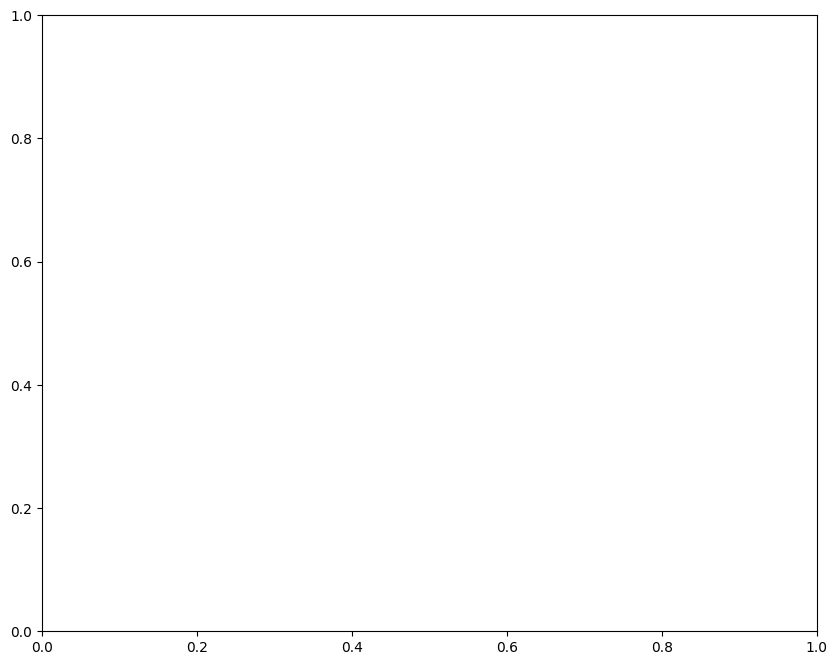

In [17]:
# Visualize latent space using PCA
# First, we need to train the encoder and encode the data
# This cell assumes valid_results, distance_matrix, and testcase_to_ndarray are available

# Extract features
test_cases_enc = [r.test_case for r in valid_results]
features_enc = np.array([testcase_to_ndarray(case) for case in test_cases_enc])

# Train encoder (using fewer epochs for quick visualization)
print("Training encoder for visualization...")
encoder_viz, scaler_viz, loss_history_viz = train_triplet_encoder(
    features_enc,
    distance_matrix,
    latent_dim=32,
    epochs=30,  # Fewer epochs for quick demo
    n_triplets=5000,
    random_seed=seed,
)

# Encode all features
encoder_viz.eval()
with torch.no_grad():
    features_scaled_viz = scaler_viz.transform(features_enc)
    features_tensor_viz = torch.FloatTensor(features_scaled_viz)
    latent_vectors_viz = encoder_viz(features_tensor_viz).numpy()

# Use PCA to project to 2D for visualization
from sklearn.decomposition import PCA

pca_viz = PCA(n_components=2)
latent_2d = pca_viz.fit_transform(latent_vectors_viz)

# Color by trajectory clusters (from earlier OPTICS clustering)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
colors_cluster = plt.get_cmap("tab10")(np.linspace(0, 1, len(unique_clusters)))

for cluster_id in unique_clusters:
    mask = clusters == cluster_id
    if cluster_id == -1:
        ax.scatter(
            latent_2d[mask, 0],
            latent_2d[mask, 1],
            c="gray",
            alpha=0.3,
            s=30,
            label="Noise",
        )
    else:
        ax.scatter(
            latent_2d[mask, 0],
            latent_2d[mask, 1],
            c=[colors_cluster[cluster_id % len(colors_cluster)]],
            alpha=0.6,
            s=30,
            label=f"Cluster {cluster_id}",
        )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(
    "Latent Space Visualization (PCA projection)\nColored by Trajectory Clusters"
)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(
    f"PCA Explained Variance: PC1={pca_viz.explained_variance_ratio_[0]:.2%}, PC2={pca_viz.explained_variance_ratio_[1]:.2%}"
)
print(f"Total explained variance: {pca_viz.explained_variance_ratio_.sum():.2%}")

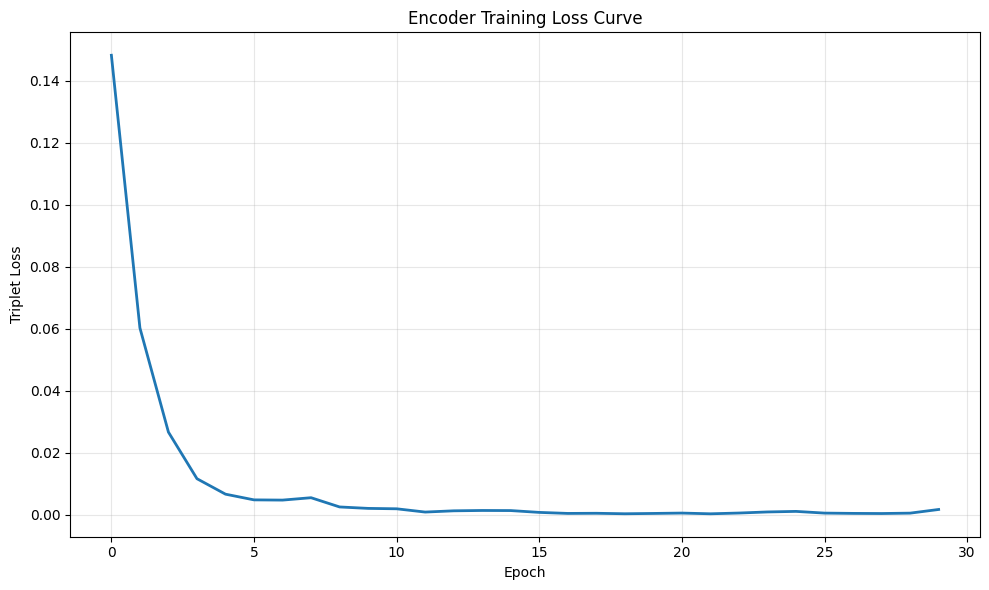

Initial loss: 0.148280
Final loss: 0.001662
Loss reduction: 98.88%


In [ ]:
# Plot training loss curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(loss_history_viz, linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Triplet Loss")
ax.set_title("Encoder Training Loss Curve")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial loss: {loss_history_viz[0]:.6f}")
print(f"Final loss: {loss_history_viz[-1]:.6f}")
print(
    f"Loss reduction: {(loss_history_viz[0] - loss_history_viz[-1]) / loss_history_viz[0] * 100:.2f}%"
)

Latent vectors shape: (328, 32)
Sample latent vector norms: [1.         1.         0.99999994 0.99999994 0.99999994]
Latent vector stats:
  Min: -0.616221, Max: 0.477598
  Mean: -0.023088, Std: 0.175263
  First few vectors (first 3 dims):
    Vector 0: [ 0.12753394  0.27784234 -0.10688267]
    Vector 1: [ 0.09237212  0.04583761 -0.08043544]
    Vector 2: [ 0.0992038   0.05239864 -0.10901632]
    Vector 3: [ 0.10157499 -0.127946   -0.14870985]
    Vector 4: [ 0.22894607 -0.05121941 -0.31028786]
R-squared: 0.7263


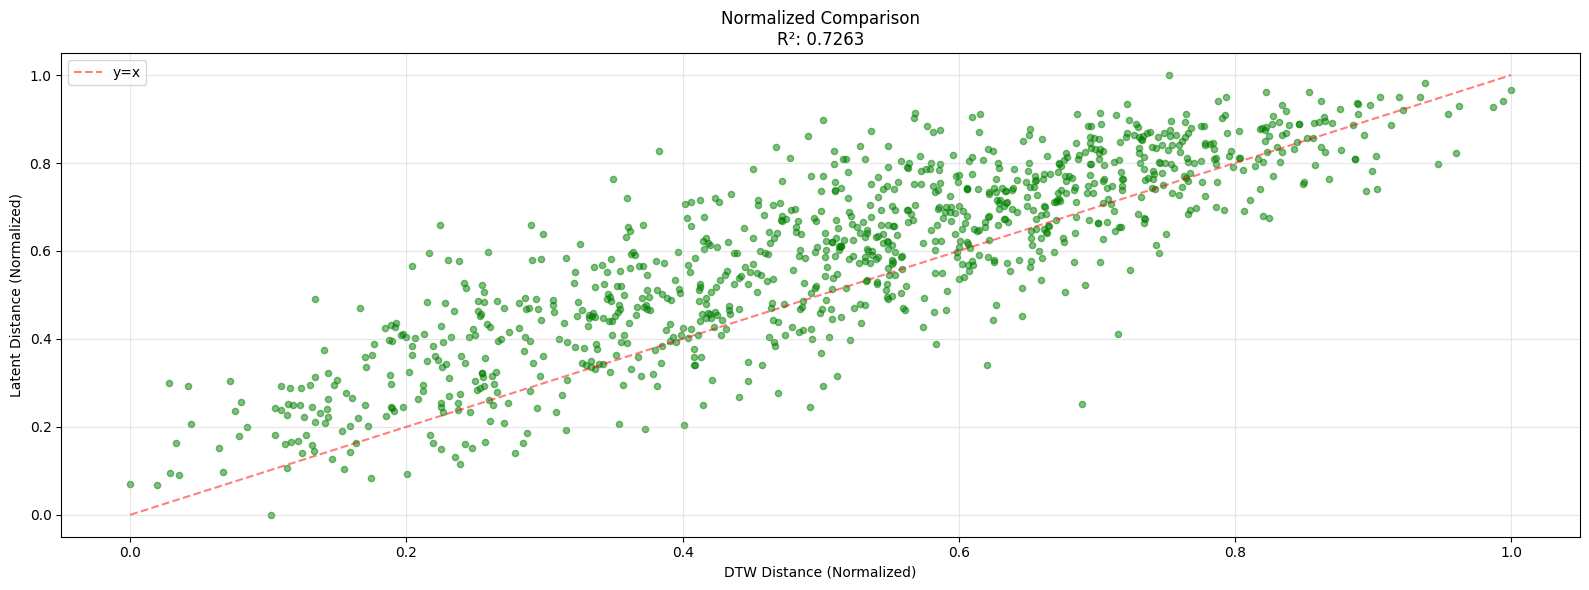

In [ ]:
# Compare DTW distances vs latent space Euclidean distances
# Sample pairs for comparison (to avoid too many points)
n_pairs = 1000
np.random.seed(seed)

# Generate random pairs (i, j) where i != j
# Adjust n_pairs if dataset is too small
max_pairs = len(features_enc) * (len(features_enc) - 1) // 2
n_pairs = min(n_pairs, max_pairs)

pair_indices = []
attempts = 0
max_attempts = n_pairs * 10

while len(pair_indices) < n_pairs and attempts < max_attempts:
    i = np.random.randint(0, len(features_enc))
    j = np.random.randint(0, len(features_enc))
    if i != j and (i, j) not in pair_indices:
        pair_indices.append((i, j))
    attempts += 1

pair_indices = np.array(pair_indices)

# Debug: Check latent vectors
print(f"Latent vectors shape: {latent_vectors_viz.shape}")
print(f"Sample latent vector norms: {np.linalg.norm(latent_vectors_viz[:5], axis=1)}")
print(f"Latent vector stats:")
print(f"  Min: {latent_vectors_viz.min():.6f}, Max: {latent_vectors_viz.max():.6f}")
print(f"  Mean: {latent_vectors_viz.mean():.6f}, Std: {latent_vectors_viz.std():.6f}")
print(f"  First few vectors (first 3 dims):")
for idx in range(min(5, len(latent_vectors_viz))):
    print(f"    Vector {idx}: {latent_vectors_viz[idx][:3]}")

dtw_distances = []
latent_distances = []

for i, j in pair_indices:
    # DTW distance
    dtw_dist = distance_matrix[i, j]
    dtw_distances.append(dtw_dist)

    # Latent space Euclidean distance
    # Since vectors are L2-normalized, distance ranges from 0 to 2
    # Distance = sqrt(2 - 2*cos(angle)) = sqrt(2*(1 - dot_product))
    vec_i = latent_vectors_viz[i]
    vec_j = latent_vectors_viz[j]
    latent_dist = np.linalg.norm(vec_i - vec_j)
    latent_distances.append(latent_dist)

dtw_distances = np.array(dtw_distances)
latent_distances = np.array(latent_distances)

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(latent_distances.reshape(-1, 1), dtw_distances)
r_squared = r2_score(dtw_distances, lr.predict(latent_distances.reshape(-1, 1)))
print(f"R-squared: {r_squared:.4f}")


# Plot comparison with proper scaling
fig, ax = plt.subplots(1, 1, figsize=(16, 6))


# Normalize both distances to [0, 1] for fair comparison
dtw_norm = (dtw_distances - dtw_distances.min()) / (
    dtw_distances.max() - dtw_distances.min() + 1e-10
)
latent_norm = (latent_distances - latent_distances.min()) / (
    latent_distances.max() - latent_distances.min() + 1e-10
)
ax.scatter(dtw_norm, latent_norm, alpha=0.5, s=20, color="green")
ax.set_xlabel("DTW Distance (Normalized)")
ax.set_ylabel("Latent Distance (Normalized)")
ax.set_title(f"Normalized Comparison\nR²: {r_squared:.4f}")
ax.grid(True, alpha=0.3)
# Add diagonal line for normalized plot
ax.plot([0, 1], [0, 1], "r--", alpha=0.5, label="y=x")
ax.legend()

plt.tight_layout()
plt.show()

## Coverage Distance


In [49]:
from sklearn.neighbors import BallTree
import time

LATENT_DIM = 32

In [50]:
# Proposed Method: Coverage Distance with Distance Predictor + Encoder
# This function uses a distance predictor to estimate distances, then trains an encoder
# on the predicted distances (not actual DTW distances), creating a latent space where
# distances approximate predicted distances rather than actual DTW distances
def coverage_distance_with_predictor(
    init_cases,
    cycles=3,
    n_candidates=10000,
    latent_dim=LATENT_DIM,
    encoder_epochs=30,
    n_triplets=5000,
    seed=100,
    cache_distances=True,
):
    np.random.seed(seed)
    torch.manual_seed(seed)
    print("Proposed Method: Distance Predictor + Encoder on Predicted Distances")
    # Evaluate initial cases
    results = evaluate_cases(init_cases)
    valid_results = [r for r in results if not r.simulation_failed]
    trajectories = [r.trajectory for r in valid_results]
    features = np.array([testcase_to_ndarray(r.test_case) for r in valid_results])

    # Calculate actual DTW distance matrix for training predictor
    distance_matrix_file = (
        f"cache/coverage_dist_matrix_seed{seed}_size{len(trajectories)}.npy"
    )
    if cache_distances and os.path.exists(distance_matrix_file):
        actual_distance_matrix = np.load(distance_matrix_file)
    else:
        actual_distance_matrix = pairwise_distances(trajectories, distance_type="dtw")
        if cache_distances:
            os.makedirs("cache", exist_ok=True)
            np.save(distance_matrix_file, actual_distance_matrix)
    # Train distance predictor
    X_pairwise, y_pairwise = create_pairwise_features(features, actual_distance_matrix)
    # Split for training (use all data for predictor since we need predictions for all pairs)
    scaler_predictor = StandardScaler()
    X_pairwise_scaled = scaler_predictor.fit_transform(X_pairwise)
    predictor = RandomForestRegressor(
        n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
    )
    predictor.fit(X_pairwise_scaled, y_pairwise)

    # Compute predicted distance matrix
    n = len(features)
    predicted_distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if i == j:
                predicted_distance_matrix[i, j] = 0.0
            else:
                pair_features = pair_features_between(features[i], features[j])
                pair_features_scaled = scaler_predictor.transform(
                    pair_features.reshape(1, -1)
                )
                pred = predictor.predict(pair_features_scaled)[0]
                predicted_distance_matrix[i, j] = pred
                predicted_distance_matrix[j, i] = pred

    # Train encoder on PREDICTED distances (not actual DTW distances)
    encoder, scaler_encoder, _ = train_triplet_encoder(
        features,
        predicted_distance_matrix,  # Use predicted distances, not actual!
        latent_dim=latent_dim,
        epochs=encoder_epochs,
        n_triplets=n_triplets,
        random_seed=seed,
    )
    # Encode all initial conditions
    encoder.eval()
    with torch.no_grad():
        features_scaled = scaler_encoder.transform(features)
        features_tensor = torch.FloatTensor(features_scaled)
        latent_vectors = encoder(features_tensor).numpy()
    # Build BallTree on latent vectors
    balltree = BallTree(latent_vectors, metric="euclidean")
    # Active learning loop
    all_results = valid_results.copy()
    all_features = features.copy()
    all_latent = latent_vectors.copy()
    all_trajectories = trajectories.copy()
    # Track which points are initial vs newly generated
    point_types = ["initial"] * len(latent_vectors)
    coverage_history = []
    for cycle in range(1, cycles + 1):
        # Generate candidate initial conditions
        candidates = generate_cases(n_candidates)
        candidate_features = np.array([testcase_to_ndarray(c) for c in candidates])
        # Encode candidates
        with torch.no_grad():
            candidate_features_scaled = scaler_encoder.transform(candidate_features)
            candidate_features_tensor = torch.FloatTensor(candidate_features_scaled)
            candidate_latent = encoder(candidate_features_tensor).numpy()
        # Find farthest candidate from its nearest neighbor
        distances, indices = balltree.query(candidate_latent, k=1)
        distances = distances.flatten()
        indices = indices.flatten()
        best_idx = np.argmax(distances)
        best_candidate = candidates[best_idx]
        coverage_distance = distances[best_idx]
        # Determine if nearest neighbor is initial or newly generated
        nearest_neighbor_idx = indices[best_idx]
        nearest_neighbor_type = point_types[nearest_neighbor_idx]
        # Calculate separate coverage distances for initial vs newly generated points
        coverage_distance_initial = (
            distances[best_idx] if nearest_neighbor_type == "initial" else None
        )
        coverage_distance_new = (
            distances[best_idx] if nearest_neighbor_type == "new" else None
        )
        # Also check all candidates to find max distances to initial vs new points separately
        distances_to_initial = []
        distances_to_new = []
        for i, nn_idx in enumerate(indices):
            if point_types[nn_idx] == "initial":
                distances_to_initial.append(distances[i])
            else:
                distances_to_new.append(distances[i])
        max_distance_to_initial = (
            max(distances_to_initial) if distances_to_initial else None
        )
        max_distance_to_new = max(distances_to_new) if distances_to_new else None
        # Evaluate best candidate
        new_results = evaluate_cases([best_candidate])
        new_valid = [r for r in new_results if not r.simulation_failed]
        if len(new_valid) == 0:
            continue
        # Add to collection
        all_results.extend(new_valid)
        new_features = np.array([testcase_to_ndarray(r.test_case) for r in new_valid])
        all_features = np.vstack([all_features, new_features])
        new_trajectories = [r.trajectory for r in new_valid]
        all_trajectories.extend(new_trajectories)
        # Update point types: add 'new' for each newly added point
        point_types.extend(["new"] * len(new_features))
        # Update predicted distance matrix
        n_new = len(new_features)
        n_old = len(predicted_distance_matrix)
        n_total = n_old + n_new
        # Expand predicted distance matrix
        new_predicted_matrix = np.zeros((n_total, n_total))
        new_predicted_matrix[:n_old, :n_old] = predicted_distance_matrix
        # Predict distances for new points
        for i in range(n_old):
            for j in range(n_old, n_total):
                pair_features = pair_features_between(all_features[i], all_features[j])
                pair_features_scaled = scaler_predictor.transform(
                    pair_features.reshape(1, -1)
                )
                pred = predictor.predict(pair_features_scaled)[0]
                new_predicted_matrix[i, j] = pred
                new_predicted_matrix[j, i] = pred
        # Predict distances between new points
        for i in range(n_old, n_total):
            for j in range(i, n_total):
                if i == j:
                    new_predicted_matrix[i, j] = 0.0
                else:
                    pair_features = pair_features_between(
                        all_features[i], all_features[j]
                    )
                    pair_features_scaled = scaler_predictor.transform(
                        pair_features.reshape(1, -1)
                    )
                    pred = predictor.predict(pair_features_scaled)[0]
                    new_predicted_matrix[i, j] = pred
                    new_predicted_matrix[j, i] = pred
        predicted_distance_matrix = new_predicted_matrix
        # Retrain encoder on updated predicted distance matrix
        encoder, scaler_encoder, _ = train_triplet_encoder(
            all_features,
            predicted_distance_matrix,
            latent_dim=latent_dim,
            epochs=encoder_epochs,
            n_triplets=n_triplets,
            random_seed=seed,
        )
        # Re-encode all points
        encoder.eval()
        with torch.no_grad():
            all_features_scaled = scaler_encoder.transform(all_features)
            all_features_tensor = torch.FloatTensor(all_features_scaled)
            all_latent = encoder(all_features_tensor).numpy()
        # Rebuild BallTree
        balltree = BallTree(all_latent, metric="euclidean")

        coverage_history.append(
            {
                "cycle": cycle,
                "coverage_distance": coverage_distance,
                "coverage_distance_initial": coverage_distance_initial,
                "coverage_distance_new": coverage_distance_new,
                "max_distance_to_initial": max_distance_to_initial,
                "max_distance_to_new": max_distance_to_new,
                "n_total": len(all_results),
            }
        )
        print(f"Cycle {cycle}/{cycles}: n={len(all_results)}")
    return all_results, all_trajectories, all_features, coverage_history

In [51]:
# Comparison: Run the Proposed Method
# Use same initial conditions and parameters for fair comparison

# Prepare initial test cases
initial_cases_coverage = generate_cases(40)
seed = 100

print(
    f"Coverage Distance Evaluation: {len(initial_cases_coverage)} initial cases, 3 cycles, 10000 candidates/cycle"
)

# Run Proposed Method: Distance Predictor + Encoder on Predicted Distances
import time

start_time = time.time()
(
    results_proposed,
    trajectories_proposed,
    features_proposed,
    coverage_history_proposed,
) = coverage_distance_with_predictor(
    init_cases=initial_cases_coverage,
    cycles=20,
    n_candidates=10000,
    latent_dim=LATENT_DIM,
    encoder_epochs=20,
    n_triplets=5000,
    seed=seed,
    cache_distances=True,
)
time_proposed = time.time() - start_time
print(f"Proposed Method: {time_proposed:.1f}s")

Coverage Distance Evaluation: 40 initial cases, 3 cycles, 10000 candidates/cycle
Proposed Method: Distance Predictor + Encoder on Predicted Distances
Generated 5000 valid triplets
Positive threshold (percentile 20): 1282381.08
Negative threshold (percentile 80): 2232331.60
Training Triplet Encoder...
  Input dimension: 8
  Latent dimension: 32
  Number of triplets: 5000
  Batch size: 64
  Epochs: 20
  Margin: 0.5

Epoch 1/20 - Average Loss: 0.110171
Epoch 10/20 - Average Loss: 0.000000
Epoch 20/20 - Average Loss: 0.000000

Training completed!
Final loss: 0.000000
Generated 5000 valid triplets
Positive threshold (percentile 20): 1299407.52
Negative threshold (percentile 80): 2219929.09
Training Triplet Encoder...
  Input dimension: 8
  Latent dimension: 32
  Number of triplets: 5000
  Batch size: 64
  Epochs: 20
  Margin: 0.5

Epoch 1/20 - Average Loss: 0.116562
Epoch 10/20 - Average Loss: 0.000000
Epoch 20/20 - Average Loss: 0.000000

Training completed!
Final loss: 0.000000
Cycle 1/20

In [52]:
# Compare results: Coverage metrics, computational time, and distance statistics

print(f"{'Metric':<30} {'Proposed Method':<20}")
print("-" * 70)

# Number of unique trajectories
print(f"\n{'Total Trajectories':<30} {len(trajectories_proposed):<30}")

# Computational time
print(f"\n{'Computational Time (seconds)':<30} {time_proposed:<30.2f}")

Metric                         Proposed Method     
----------------------------------------------------------------------

Total Trajectories             52                            

Computational Time (seconds)   79.10                         


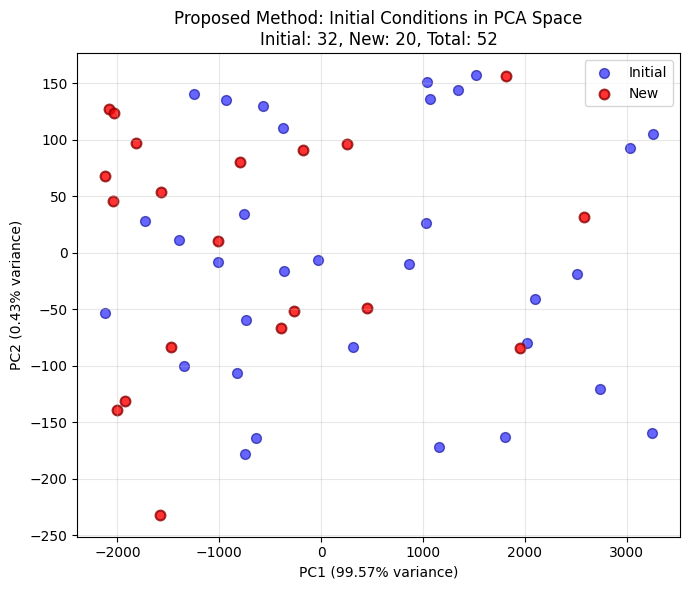

In [53]:
# Visualize initial conditions in feature space using PCA
# Differentiate between initial data and newly generated data with different colors

from sklearn.decomposition import PCA

# Determine number of initial valid cases from coverage history
# The first entry in coverage_history shows the state after the first cycle
# Before any cycles, we have only initial cases

if coverage_history_proposed and len(coverage_history_proposed) > 0:
    n_initial_proposed = coverage_history_proposed[0]["n_total"] - 1
else:
    n_initial_proposed = len(initial_cases_coverage)

# Combine features from both methods for consistent PCA
all_features_combined = features_proposed
pca = PCA(n_components=2)
pca.fit(all_features_combined)

# Transform both datasets
features_proposed_pca = pca.transform(features_proposed)

# Split into initial and newly generated for Proposed Method
features_proposed_initial_pca = features_proposed_pca[:n_initial_proposed]
features_proposed_new_pca = features_proposed_pca[n_initial_proposed:]

# Plot
fig, ax2 = plt.subplots(1, 1, figsize=(7, 6))

# Proposed Method
# Plot initial conditions
if len(features_proposed_initial_pca) > 0:
    scatter_proposed_initial = ax2.scatter(
        features_proposed_initial_pca[:, 0],
        features_proposed_initial_pca[:, 1],
        alpha=0.6,
        s=50,
        c="blue",
        label="Initial",
        edgecolors="darkblue",
        linewidths=1,
    )
# Plot newly generated conditions
if len(features_proposed_new_pca) > 0:
    scatter_proposed_new = ax2.scatter(
        features_proposed_new_pca[:, 0],
        features_proposed_new_pca[:, 1],
        alpha=0.8,
        s=50,
        c="red",
        label="New",
        edgecolors="darkred",
        linewidths=1.5,
    )
ax2.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
ax2.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
ax2.set_title(
    f"Proposed Method: Initial Conditions in PCA Space\nInitial: {len(features_proposed_initial_pca)}, New: {len(features_proposed_new_pca)}, Total: {len(features_proposed)}"
)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [54]:
# Evaluate Coverage of Generated TestCases
# This function evaluates how well a set of generated test cases covers the input space
# by comparing DTW distances between newly generated points and a representative set


def evaluate_coverage(
    generated_cases: list[TestCase],
    representative_cases: list[TestCase],
    n_samples: int = 100,
    seed: int = 100,
    use_encoder: bool = True,
    latent_dim: int = LATENT_DIM,
    encoder_epochs: int = 30,
    n_triplets: int = 5000,
) -> dict:
    """
    Evaluate coverage of generated test cases by measuring distances to representative points.

    If the generated set has good coverage, any random newly generated point should not be
    too far from the representative set (i.e., minimum distances should be small).

    Args:
        generated_cases: List of newly generated TestCases to evaluate
        representative_cases: List of representative TestCases (e.g., initial/training set)
        n_samples: Number of random samples to draw from generated_cases for evaluation
        seed: Random seed for reproducibility
        use_encoder: If True, use encoder for efficient distance estimation;
                     if False, compute actual DTW distances (slower but exact)
        latent_dim: Dimension of latent space (if use_encoder=True)
        encoder_epochs: Number of training epochs for encoder (if use_encoder=True)
        n_triplets: Number of triplets for encoder training (if use_encoder=True)

    Returns:
        Dictionary containing:
            - 'min_distances': Array of minimum distances for each sampled point
            - 'mean_min_distance': Mean of minimum distances (lower = better coverage)
            - 'max_min_distance': Maximum of minimum distances (lower = better coverage)
            - 'median_min_distance': Median of minimum distances
            - 'std_min_distance': Standard deviation of minimum distances
            - 'coverage_score': Overall coverage score (lower = better)
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    print("COVERAGE EVALUATION")
    print(
        f"Generated: {len(generated_cases)}, Representative: {len(representative_cases)}, Samples: {n_samples}"
    )

    # Randomly sample from generated cases
    n_samples = min(n_samples, len(generated_cases))
    sample_indices = np.random.choice(
        len(generated_cases), size=n_samples, replace=False
    )
    sampled_cases = [generated_cases[i] for i in sample_indices]

    # Convert to features
    generated_features = np.array([testcase_to_ndarray(tc) for tc in sampled_cases])
    representative_features = np.array(
        [testcase_to_ndarray(tc) for tc in representative_cases]
    )

    if use_encoder:
        # Evaluate representative cases to get trajectories
        rep_results = evaluate_cases(representative_cases)
        rep_valid = [r for r in rep_results if not r.simulation_failed]
        rep_trajectories = [r.trajectory for r in rep_valid]
        rep_features_valid = np.array(
            [testcase_to_ndarray(r.test_case) for r in rep_valid]
        )

        # Calculate DTW distance matrix for representative set
        rep_distance_matrix = pairwise_distances(rep_trajectories, distance_type="dtw")

        # Train encoder on representative set
        encoder, scaler, _ = train_triplet_encoder(
            rep_features_valid,
            rep_distance_matrix,
            latent_dim=latent_dim,
            epochs=encoder_epochs,
            n_triplets=n_triplets,
            random_seed=seed,
        )

        # Encode representative set
        encoder.eval()
        with torch.no_grad():
            rep_scaled = scaler.transform(rep_features_valid)
            rep_tensor = torch.FloatTensor(rep_scaled)
            rep_latent = encoder(rep_tensor).numpy()

        # Build BallTree on representative latent vectors
        balltree = BallTree(rep_latent, metric="euclidean")

        # Encode sampled generated cases
        with torch.no_grad():
            gen_scaled = scaler.transform(generated_features)
            gen_tensor = torch.FloatTensor(gen_scaled)
            gen_latent = encoder(gen_tensor).numpy()

        # Find minimum distance from each generated point to representative set
        distances, _ = balltree.query(gen_latent, k=1)
        min_distances = distances.flatten()

    else:
        # Compute actual DTW distances (slower but exact)
        # Evaluate both sets to get trajectories
        gen_results = evaluate_cases(sampled_cases)
        rep_results = evaluate_cases(representative_cases)

        gen_valid = [r for r in gen_results if not r.simulation_failed]
        rep_valid = [r for r in rep_results if not r.simulation_failed]

        gen_trajectories = [r.trajectory for r in gen_valid]
        rep_trajectories = [r.trajectory for r in rep_valid]

        # Compute DTW distances between generated and representative sets
        min_distances = []

        for gen_traj in gen_trajectories:
            # Find minimum DTW distance to any representative trajectory
            distances_to_rep = []
            for rep_traj in rep_trajectories:
                dist = dtw_distance(gen_traj, rep_traj)
                distances_to_rep.append(dist)
            min_dist = min(distances_to_rep) if distances_to_rep else np.inf
            min_distances.append(min_dist)

        min_distances = np.array(min_distances)

    # Calculate coverage statistics
    mean_min_dist = float(np.mean(min_distances))
    max_min_dist = float(np.max(min_distances))
    median_min_dist = float(np.median(min_distances))
    std_min_dist = float(np.std(min_distances))

    # Coverage score: combination of mean and max (lower is better)
    # Good coverage means all points are close to some representative
    coverage_score = mean_min_dist + 0.5 * max_min_dist

    print(
        f"Mean min dist: {mean_min_dist:.4f}, Max min dist: {max_min_dist:.4f}, Coverage score: {coverage_score:.4f}"
    )

    return {
        "min_distances": min_distances,
        "mean_min_distance": mean_min_dist,
        "max_min_distance": max_min_dist,
        "median_min_distance": median_min_dist,
        "std_min_distance": std_min_dist,
        "coverage_score": coverage_score,
    }

In [ ]:
# Compare Coverage: Proposed Method (Predictor), and Random Baseline


# Use the same initial cases as representative set
representative_set_comparison = initial_cases_coverage

# Proposed Method: Cases generated by predictor method (from coverage_distance_with_predictor)
predictor_generated_cases = [
    r.test_case for r in results_proposed if not r.simulation_failed
]

# Baseline: Randomly generated cases (same number as encoder method for fair comparison)
# Set seed for reproducibility of the baseline set
np.random.seed(105)
n_random = len(predictor_generated_cases)
random_generated_cases = generate_cases(n_random)

print(f"\nRepresentative set size: {len(representative_set_comparison)}")
print(f"Proposed Method (Predictor) generated cases: {len(predictor_generated_cases)}")
print(f"Random baseline cases: {len(random_generated_cases)}")

# Evaluation Seed: Use the SAME seed for both evaluations to ensure the
# encoder (the "ruler") is trained identically for a fair comparison.
EVAL_SEED = 102

# Evaluate Proposed Method (Predictor) coverage
print("\n" + "-" * 80)
print("Evaluating Proposed Method (Predictor) Coverage...")
print("-" * 80)
predictor_coverage = evaluate_coverage(
    generated_cases=predictor_generated_cases,
    representative_cases=representative_set_comparison,
    n_samples=min(100, len(predictor_generated_cases)),
    seed=EVAL_SEED,
    use_encoder=False,
    latent_dim=LATENT_DIM,
    encoder_epochs=30,
    n_triplets=5000,
)

# Evaluate random baseline coverage
print("\n" + "-" * 80)
print("Evaluating Random Baseline Coverage...")
print("-" * 80)
random_coverage = evaluate_coverage(
    generated_cases=random_generated_cases,
    representative_cases=representative_set_comparison,
    n_samples=min(100, len(random_generated_cases)),
    seed=EVAL_SEED,  # Same seed as above for fair comparison
    use_encoder=False,
    latent_dim=LATENT_DIM,
    encoder_epochs=30,
    n_triplets=5000,
)


Representative set size: 40
Proposed Method (Predictor) generated cases: 52
Random baseline cases: 52

--------------------------------------------------------------------------------
Evaluating Proposed Method (Predictor) Coverage...
--------------------------------------------------------------------------------
COVERAGE EVALUATION
Generated: 52, Representative: 40, Samples: 52
Generated 5000 valid triplets
Positive threshold (percentile 20): 968904.83
Negative threshold (percentile 80): 2493168.91
Training Triplet Encoder...
  Input dimension: 8
  Latent dimension: 32
  Number of triplets: 5000
  Batch size: 64
  Epochs: 30
  Margin: 0.5

Epoch 1/30 - Average Loss: 0.034811
Epoch 10/30 - Average Loss: 0.000000
Epoch 20/30 - Average Loss: 0.000000
Epoch 30/30 - Average Loss: 0.000000

Training completed!
Final loss: 0.000000
Mean min dist: 0.1784, Max min dist: 0.7901, Coverage score: 0.5735

--------------------------------------------------------------------------------
Evaluating

In [56]:
# Display comparison table

print(f"{'Metric':<30} {'Proposed Method':<18} {'Random':<18}")
print(f"{'':30} {'(Predictor)':<18} {'(Baseline)':<18}")
print("-" * 80)

metrics_to_compare = [
    ("Mean Min Distance", "mean_min_distance"),
    ("Max Min Distance", "max_min_distance"),
    ("Median Min Distance", "median_min_distance"),
    ("Std Min Distance", "std_min_distance"),
    ("Coverage Score", "coverage_score"),
]

for metric_name, metric_key in metrics_to_compare:
    predictor_val = predictor_coverage[metric_key]
    random_val = random_coverage[metric_key]

    print(f"{metric_name:<30} {predictor_val:<18.4f} {random_val:<18.4f}")

Metric                         Proposed Method    Random            
                               (Predictor)        (Baseline)        
--------------------------------------------------------------------------------
Mean Min Distance              0.1784             0.3446            
Max Min Distance               0.7901             0.7132            
Median Min Distance            0.0000             0.3191            
Std Min Distance               0.2484             0.1073            
Coverage Score                 0.5735             0.7012            


/var/folders/xc/5zwwryv54b9cssx5nwq1wfr00000gn/T/ipykernel_24730/2806339062.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(


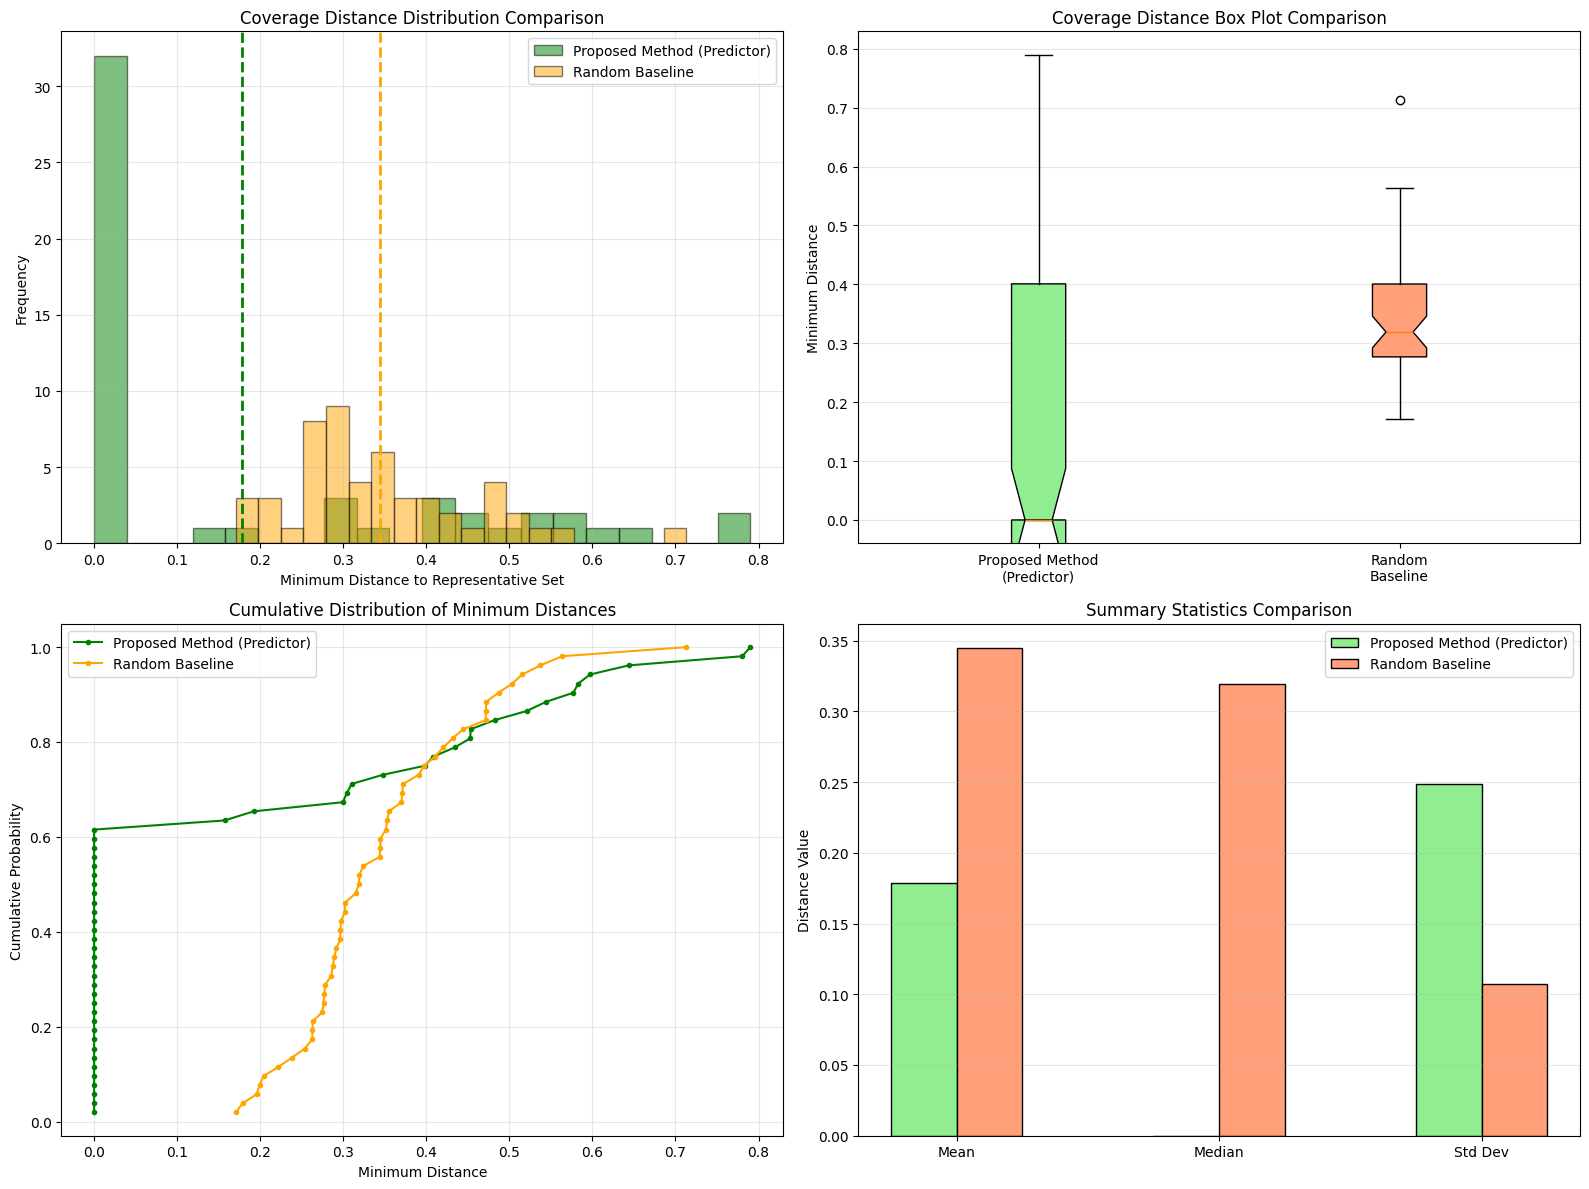

In [57]:
# Visualize coverage comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram comparison
ax1 = axes[0, 0]
ax1.hist(
    predictor_coverage["min_distances"],
    bins=20,
    alpha=0.5,
    color="green",
    edgecolor="black",
    label="Proposed Method (Predictor)",
)
ax1.hist(
    random_coverage["min_distances"],
    bins=20,
    alpha=0.5,
    color="orange",
    edgecolor="black",
    label="Random Baseline",
)
ax1.axvline(
    predictor_coverage["mean_min_distance"],
    color="green",
    linestyle="--",
    linewidth=2,
)
ax1.axvline(
    random_coverage["mean_min_distance"],
    color="orange",
    linestyle="--",
    linewidth=2,
)
ax1.set_xlabel("Minimum Distance to Representative Set")
ax1.set_ylabel("Frequency")
ax1.set_title("Coverage Distance Distribution Comparison")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot comparison
ax2 = axes[0, 1]
box_data = [
    predictor_coverage["min_distances"],
    random_coverage["min_distances"],
]
bp = ax2.boxplot(
    box_data,
    labels=["Proposed Method\n(Predictor)", "Random\nBaseline"],
    patch_artist=True,
    notch=True,
)
bp["boxes"][0].set_facecolor("lightgreen")
bp["boxes"][1].set_facecolor("lightsalmon")
ax2.set_ylabel("Minimum Distance")
ax2.set_title("Coverage Distance Box Plot Comparison")
ax2.grid(True, alpha=0.3, axis="y")

# 3. Cumulative distribution comparison
ax3 = axes[1, 0]
sorted_predictor = np.sort(predictor_coverage["min_distances"])
sorted_random = np.sort(random_coverage["min_distances"])

y_predictor = np.arange(1, len(sorted_predictor) + 1) / len(sorted_predictor)
y_random = np.arange(1, len(sorted_random) + 1) / len(sorted_random)

ax3.plot(
    sorted_predictor,
    y_predictor,
    marker=".",
    linestyle="-",
    color="green",
    label="Proposed Method (Predictor)",
)
ax3.plot(
    sorted_random,
    y_random,
    marker=".",
    linestyle="-",
    color="orange",
    label="Random Baseline",
)
ax3.set_xlabel("Minimum Distance")
ax3.set_ylabel("Cumulative Probability")
ax3.set_title("Cumulative Distribution of Minimum Distances")
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Summary metrics bar chart
ax4 = axes[1, 1]
metrics = ["Mean", "Median", "Std Dev"]
predictor_vals = [
    predictor_coverage["mean_min_distance"],
    predictor_coverage["median_min_distance"],
    predictor_coverage["std_min_distance"],
]
random_vals = [
    random_coverage["mean_min_distance"],
    random_coverage["median_min_distance"],
    random_coverage["std_min_distance"],
]

x = np.arange(len(metrics))
width = 0.25

bars2 = ax4.bar(
    x,
    predictor_vals,
    width,
    label="Proposed Method (Predictor)",
    color="lightgreen",
    edgecolor="black",
)
bars3 = ax4.bar(
    x + width,
    random_vals,
    width,
    label="Random Baseline",
    color="lightsalmon",
    edgecolor="black",
)

ax4.set_ylabel("Distance Value")
ax4.set_title("Summary Statistics Comparison")
ax4.set_xticks(x + width / 2)
ax4.set_xticklabels(metrics)
ax4.legend()
ax4.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()